In [45]:
import pandas as pd
from scipy import stats
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg

%pylab inline
variant1 = "_840"
variant2 = "_1023"
variant = variant1

Populating the interactive namespace from numpy and matplotlib


Loading Data

In [46]:

data_path = {"HD_Cluster":"./HD_Analysis/speeches_analysis/", 
            "HD_Topic":"./HD_Analysis/topic_analysis/",
             "IJ_Clusster":"./IJCNN_analysis/cluster_analysis/",
             "IJ_Topic":"./IJCNN_analysis/topic_analysis/"}
data_set = "HD_Cluster"

som_path = "../Pipeline/Reference/"

orig_cluster_df = pd.read_pickle(data_path[data_set] + "cluster_df" + variant + "_HD.pkl")
# Setting data format
orig_doc_label_all_truncated = pd.read_pickle(data_path[data_set]
        + "doc_label_all_truncated" + variant + ".pkl") 

orig_doc_label_all_truncated['local_cluster'] = orig_doc_label_all_truncated[0].apply(int)
orig_doc_label_all_truncated['speech_id'] = orig_doc_label_all_truncated['id'].apply(int)
orig_doc_label_all_truncated['global_cluster'] = orig_doc_label_all_truncated['cluster'].apply(int)
orig_doc_label_all_truncated['year'] = orig_doc_label_all_truncated['year'].str.replace("speeches_", "")
orig_doc_label_all_truncated.drop([0,'cluster', "id"], inplace=True, axis=1)

In [47]:
dic_speaker_map ={}
dic_decsr = {}

dic_neuron = {}
lst_neuron = []
dic_doc_label_year = {}
congress = ["097", "098", "099", "100", "101", "102", "103", 
         "104", "105", "106", "107", "108", "109", "110", 
         "111", "112", "113", "114"]
years = ["81-82", "83-84", "85-86", "87-88", "89-90", "91-92", "93-94", 
         "95-96", "97-98", "99-00", "01-02", "03-04", "05-06", "07-08", 
         "09-10", "11-12", "13-14", "15-16"]

year_map = dict(zip(congress, years))

orig_doc_label_all_truncated.replace({"year":year_map}, inplace=True)
orig_doc_label_all_truncated

year party  local_cluster   speech_id  global_cluster
0      81-82     D            376   970000037             111
1      81-82     D            461   970000183             145
2      81-82     D            389   970000185             115
3      81-82     D            676   970000192             213
4      81-82     D            404   970000194             120
...      ...   ...            ...         ...             ...
25682  15-16     R            114  1140112237             190
25683  15-16     R            234  1140112239             203
25684  15-16     R            114  1140112241             190
25685  15-16     R             39  1140112243             222
25686  15-16     R            214  1140112245             364

[808199 rows x 5 columns]

In [48]:
new_cols = []
for col in orig_cluster_df.columns:
    tmp = col.replace("speeches_", "")
    if len(tmp) > 3 and tmp[:3] in year_map:
        tmp  =  year_map[tmp[:3]] + tmp[3:]
    new_cols.append(tmp)
orig_cluster_df.columns = new_cols
orig_cluster_df = orig_cluster_df/ 10000.0

In [49]:
orig_cluster_df.head()

81-82_D   81-82_R   83-84_D   83-84_R   85-86_D   85-86_R   87-88_D  \
0  0.036293  0.031182  0.011726  0.011381  0.017631  0.023664  0.010703   
1  0.034487  0.035598  0.012123  0.016634  0.024653  0.026501  0.007750   
2  0.002504  0.001026  0.000676  0.000625  0.001220  0.001515  0.000938   
3  0.000370  0.000758  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.001355  0.001427  0.000000  0.000000  0.000000  0.000000  0.000000   

    87-88_R   89-90_D   89-90_R  ...   07-08_R   09-10_D   09-10_R   11-12_D  \
0  0.013232  0.015543  0.015177  ...  0.003812  0.008674  0.007918  0.023927   
1  0.011307  0.011840  0.014381  ...  0.030998  0.020983  0.058924  0.053339   
2  0.000574  0.000664  0.000575  ...  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.001467  0.002345  ...  0.001505  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

    11-12_R   13-14_D   13-14_R   15-16_D   15-16_R     sum  
0  0.031311  0.029804  0.020709  0.017270  0.010481  1.5767  
1  0.044037  0.009913  0.013339  0.012112  0.015956  2.1459  
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.0349  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.0656  
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.0065  

[5 rows x 37 columns]

In [50]:
for congress, calendar_yr in year_map.items():
    dic_speaker_map[calendar_yr] = pd.read_csv(
        data_path[data_set] + congress + "_SpeakerMap.txt", 
        sep="|", 
        on_bad_lines='skip')
    dic_speaker_map[calendar_yr].set_index("speakerid", inplace=True)
    
    dic_decsr[calendar_yr] = pd.read_csv(
        "/media/zwmtrue/OSexchange/hein-daily/descr_"+congress+".txt",
        sep="|", 
        on_bad_lines='skip')
    dic_decsr[calendar_yr].set_index("speech_id", inplace=True)
    
    dic_neuron[calendar_yr] = pd.read_pickle(som_path + "doc_neuron_speeches_" + congress + ".pkl")
    dic_neuron[calendar_yr].rename({0:"local_neuron"}, axis=1, inplace=True)

    lst_neuron.append(dic_neuron[calendar_yr].copy(deep=True))

# df_pos should be the same for all years    
df_pos = pd.read_pickle(
    som_path + "df_pos_speeches_" + congress + ".pkl"
).rename(columns={0: 'p0', 1:'p1'})

df_pos.index.names=["neuron_id"]

In [51]:
# append coordinates of neurons
df_neuron = pd.concat(lst_neuron)
df_neuron = df_neuron.merge(df_pos, left_on='local_neuron', right_on = "neuron_id", 
                how='left')
df_neuron

local_neuron    p0    p1
0               5262  62.0  52.0
1               7010  10.0  70.0
2               5818  18.0  58.0
3               9469  69.0  94.0
4               5429  29.0  54.0
...              ...   ...   ...
808194          7368  67.5  73.0
808195          5487  87.0  54.0
808196          7566  65.5  75.0
808197          1541  40.5  15.0
808198          4585  84.5  45.0

[808199 rows x 3 columns]

In [52]:
df_doc = orig_doc_label_all_truncated.copy(deep=True)
df_doc["neuron"] = df_neuron["local_neuron"]
df_doc.replace({"year":year_map}, inplace=True)
df_doc["local_p0"] = df_neuron["p0"]
df_doc["local_p1"] = df_neuron["p1"]
#df_doc.set_index(["year", "speech_id"], inplace=True)
df_doc

year party  local_cluster   speech_id  global_cluster  neuron  \
0      81-82     D            376   970000037             111    5262   
1      81-82     D            461   970000183             145    7010   
2      81-82     D            389   970000185             115    5818   
3      81-82     D            676   970000192             213    9469   
4      81-82     D            404   970000194             120    5429   
...      ...   ...            ...         ...             ...     ...   
25682  15-16     R            114  1140112237             190     899   
25683  15-16     R            234  1140112239             203     898   
25684  15-16     R            114  1140112241             190    6060   
25685  15-16     R             39  1140112243             222    5519   
25686  15-16     R            214  1140112245             364    9512   

       local_p0  local_p1  
0          62.0      52.0  
1          10.0      70.0  
2          18.0      58.0  
3          69.0      94.0  
4          29.0      54.0  
...         ...       ...  
25682      99.0       8.0  
25683      98.0       8.0  
25684      60.0      60.0  
25685      18.5      55.0  
25686      11.5      95.0  

[808199 rows x 8 columns]

In [53]:
df_speaker_map = pd.concat(dic_speaker_map)
df_speaker_map.index.names=["year","speakerid"]
df_speaker_map = df_speaker_map.reset_index(level=["year","speakerid"])
df_speaker_map.to_pickle("./HD_Analysis/speeches_analysis/df_speaker_map.pkl")
df_speaker_map

year  speakerid   speech_id    lastname firstname chamber state  \
0        81-82   97105301   970000005       PERCY   CHARLES       S    IL   
1        81-82   97105071   970000006  HUDDLESTON    WALTER       S    KY   
2        81-82   97106761   970000007     JACKSON     HENRY       S    WA   
3        81-82   97106981   970000008    STAFFORD    ROBERT       S    VT   
4        81-82   97104811   970000010       BAKER    HOWARD       S    TN   
...        ...        ...         ...         ...       ...     ...   ...   
2585802  15-16  114120860  1140111652       POLIS     JARED       H    CO   
2585803  15-16  114119880  1140112111        HURT    ROBERT       H    VA   
2585804  15-16  114118381  1140041159        REED      JOHN       S    RI   
2585805  15-16  114121330  1140082528    SESSIONS      PETE       H    TX   
2585806  15-16  114121030  1140106304      ROGERS    HAROLD       H    KY   

        gender party  district nonvoting  
0            M     R       NaN    voting  
1            M     D       NaN    voting  
2            M     D       NaN    voting  
3            M     R       NaN    voting  
4            M     R       NaN    voting  
...        ...   ...       ...       ...  
2585802      M     D       2.0    voting  
2585803      M     R       5.0    voting  
2585804      M     D       NaN    voting  
2585805      M     R      32.0    voting  
2585806      M     R       5.0    voting  

[2585807 rows x 11 columns]

In [54]:
df_descr = pd.concat(dic_decsr)
df_descr.index.names = ["year", "speech_id"]
df_descr = df_descr.reset_index(level=["year","speech_id"])
df_descr

year   speech_id chamber      date  number_within_file  \
0        81-82   970000001       S  19810105                   1   
1        81-82   970000002       S  19810105                   2   
2        81-82   970000003       S  19810105                   3   
3        81-82   970000004       S  19810105                   4   
4        81-82   970000005       S  19810105                   5   
...        ...         ...     ...       ...                 ...   
3866178  15-16  1140112286       E  20160909                 220   
3866179  15-16  1140112287       E  20160909                 221   
3866180  15-16  1140112288       E  20160909                 222   
3866181  15-16  1140112289       E  20160909                 223   
3866182  15-16  1140112290       E  20160909                 224   

                    speaker first_name last_name    state   gender  \
0        The VICE PRESIDENT    Unknown   Unknown  Unknown  Special   
1        The VICE PRESIDENT    Unknown   Unknown  Unknown  Special   
2                  The VICE    Unknown   Unknown  Unknown  Special   
3        The VICE PRESIDENT    Unknown   Unknown  Unknown  Special   
4                 Mr. PERCY    Unknown     PERCY  Unknown        M   
...                     ...        ...       ...      ...      ...   
3866178   Mr. YOUNG of Iowa    Unknown     YOUNG     Iowa        M   
3866179       Mrs. WALORSKI    Unknown  WALORSKI  Unknown        F   
3866180        Mr. LANGEVIN    Unknown  LANGEVIN  Unknown        M   
3866181    Mr. POE of Texas    Unknown       POE    Texas        M   
3866182   Mr. YOUNG of Iowa    Unknown     YOUNG     Iowa        M   

         line_start  line_end          file  char_count  word_count  
0                17        62  01051981.txt        1543         283  
1                65        74  01051981.txt         334          55  
2               200       212  01051981.txt         466          82  
3               858       864  01051981.txt         210          37  
4               883       889  01051981.txt         201          34  
...             ...       ...           ...         ...         ...  
3866178       10620     10641  09092016.txt         756         126  
3866179       10651     10694  09092016.txt        1760         300  
3866180       10701     10730  09092016.txt         495          84  
3866181       10738     10771  09092016.txt        1206         208  
3866182       10779     10954  09092016.txt        5673         909  

[3866183 rows x 15 columns]

In [55]:
df_speech_speaker = df_descr.merge(
    df_speaker_map.drop(labels=[ "chamber", "firstname", "lastname", "state", "gender"], axis=1),
    how = "inner",
    left_on = ["year","speech_id"],#, "chamber", "first_name", "last_name", "state", "gender"],
    right_on = ["year","speech_id"]
)
df_speech_speaker

year   speech_id chamber      date  number_within_file  \
0        81-82   970000005       S  19810105                   5   
1        81-82   970000006       S  19810105                   6   
2        81-82   970000007       S  19810105                   7   
3        81-82   970000008       S  19810105                   8   
4        81-82   970000010       S  19810105                  10   
...        ...         ...     ...       ...                 ...   
2585802  15-16  1140112244       H  20160909                 178   
2585803  15-16  1140112245       H  20160909                 179   
2585804  15-16  1140112246       H  20160909                 180   
2585805  15-16  1140112247       H  20160909                 181   
2585806  15-16  1140112248       H  20160909                 182   

                            speaker first_name   last_name       state gender  \
0                         Mr. PERCY    Unknown       PERCY     Unknown      M   
1                    Mr. HUDDLESTON    Unknown  HUDDLESTON     Unknown      M   
2                       Mr. JAcKSON    Unknown     JACKSON     Unknown      M   
3                      Mr. STAFFORD    Unknown    STAFFORD     Unknown      M   
4                         Mr. BAKER    Unknown       BAKER     Unknown      M   
...                             ...        ...         ...         ...    ...   
2585802                 Mr. COFFMAN    Unknown     COFFMAN     Unknown      M   
2585803                    Mr. DOLD    Unknown        DOLD     Unknown      M   
2585804  Mr. TED LIEU of California        TED        LIEU  California      M   
2585805                 Mr. BUCSHON    Unknown     BUCSHON     Unknown      M   
2585806                    Mr. DOLD    Unknown        DOLD     Unknown      M   

         line_start  line_end          file  char_count  word_count  \
0               883       889  01051981.txt         201          34   
1               895       901  01051981.txt         202          34   
2               907       913  01051981.txt         201          34   
3               932       938  01051981.txt         201          34   
4               986       987  01051981.txt          49           9   
...             ...       ...           ...         ...         ...   
2585802        7030      7050  09092016.txt         682         109   
2585803        7074      7105  09092016.txt        1041         179   
2585804        7110      7141  09092016.txt        1058         189   
2585805        7152      7179  09092016.txt         868         125   
2585806        7188      7189  09092016.txt          50          10   

         speakerid party  district nonvoting  
0         97105301     R       NaN    voting  
1         97105071     D       NaN    voting  
2         97106761     D       NaN    voting  
3         97106981     R       NaN    voting  
4         97104811     R       NaN    voting  
...            ...   ...       ...       ...  
2585802  114118980     R       6.0    voting  
2585803  114122790     R      10.0    voting  
2585804  114122890     D      33.0    voting  
2585805  114118760     R       8.0    voting  
2585806  114122790     R      10.0    voting  

[2585807 rows x 19 columns]

In [56]:
df_speech_orig = df_doc.merge(
    df_speech_speaker.drop(
        labels=["party", "number_within_file", "speaker", "line_start", "line_end", 
                "file", "first_name", "last_name"],
        axis=1),
    how = "inner",
    left_on = ["year","speech_id"],
    right_on = ["year","speech_id"]
)
df_speech_orig["district"] = df_speech_orig["district"].fillna(0).apply(int)

df_speech_orig["nonvoting"] = df_speech_orig["nonvoting"] != "voting"

In [57]:
# filter out speeches w no assigned cluster
df_speech = df_speech_orig[df_speech_orig['global_cluster'] != -1]

df_speech.to_pickle("./HD_Analysis/speeches_analysis/df_speech.pkl")
df_speech

year party  local_cluster   speech_id  global_cluster  neuron  \
0       81-82     D            376   970000037             111    5262   
1       81-82     D            461   970000183             145    7010   
2       81-82     D            389   970000185             115    5818   
3       81-82     D            676   970000192             213    9469   
4       81-82     D            404   970000194             120    5429   
...       ...   ...            ...         ...             ...     ...   
808194  15-16     R            114  1140112237             190     899   
808195  15-16     R            234  1140112239             203     898   
808196  15-16     R            114  1140112241             190    6060   
808197  15-16     R             39  1140112243             222    5519   
808198  15-16     R            214  1140112245             364    9512   

        local_p0  local_p1 chamber      date         state gender  char_count  \
0           62.0      52.0       S  19810105       Unknown      M        2264   
1           10.0      70.0       S  19810105       Unknown      M        5347   
2           18.0      58.0       S  19810105       Unknown      M        3119   
3           69.0      94.0       S  19810105       Unknown      M        4040   
4           29.0      54.0       S  19810105       Unknown      M        3050   
...          ...       ...     ...       ...           ...    ...         ...   
808194      99.0       8.0       H  20160909          Iowa      M        1482   
808195      98.0       8.0       H  20160909       Unknown      M        1026   
808196      60.0      60.0       H  20160909  Pennsylvania      M        1153   
808197      18.5      55.0       H  20160909       Unknown      M        1744   
808198      11.5      95.0       H  20160909       Unknown      M        1041   

        word_count  speakerid  district  nonvoting  
0              415   97114621         0      False  
1              824   97109651         0      False  
2              508   97108781         0      False  
3              649   97107681         0      False  
4              517   97108511         0      False  
...            ...        ...       ...        ...  
808194         271  114123000         3      False  
808195         166  114123320         4      False  
808196         181  114121520         5      False  
808197         295  114121990         1      False  
808198         179  114122790        10      False  

[806594 rows x 17 columns]

Next we find gender specific distribution of doc/speech over neurons

Generate the same data points across years for different gender

In [58]:
df_agg = pd.DataFrame(
    df_speech[df_speech["gender"] != "Unknown"]\
    .groupby(["year",'global_cluster', 'gender']).size())
df_agg

0
year  global_cluster gender      
01-02 0              F         41
                     M        429
      1              F        132
                     M       1026
      3              F         18
...                           ...
99-00 646            F         18
                     M        155
      647            M          9
      648            F        104
                     M        551

[8579 rows x 1 columns]

In [59]:
df_agg_gender = df_agg/df_agg.groupby(level=['gender','year']).sum()
df_agg_gender

0
year  gender global_cluster          
01-02 F      0               0.006664
             1               0.021456
             3               0.002926
             6               0.009428
             7               0.002763
...                               ...
99-00 M      644             0.000239
             645             0.000239
             646             0.003702
             647             0.000215
             648             0.013160

[8579 rows x 1 columns]

In [60]:
df_gender = df_agg_gender.reset_index(level=["year","gender"])
df_gender

year gender         0
global_cluster                        
0               01-02      F  0.006664
1               01-02      F  0.021456
3               01-02      F  0.002926
6               01-02      F  0.009428
7               01-02      F  0.002763
...               ...    ...       ...
644             99-00      M  0.000239
645             99-00      M  0.000239
646             99-00      M  0.003702
647             99-00      M  0.000215
648             99-00      M  0.013160

[8579 rows x 3 columns]

In [61]:
df_cluster_M = df_gender[df_gender["gender"] == "M"]
df_cluster_M = df_cluster_M.drop(labels=["gender"],axis=1)
df_cluster_M = df_cluster_M.rename({0:"cnt"}, axis=1)
df_cluster_M = df_cluster_M.pivot_table(values='cnt', index=df_cluster_M.index, columns="year")#, aggfunc='first')
df_cluster_M = df_cluster_M.fillna(0)
df_cluster_M

year               01-02     03-04     05-06     07-08     09-10     11-12  \
global_cluster                                                               
0               0.012564  0.011605  0.012873  0.008606  0.008993  0.028453   
1               0.030049  0.034736  0.025241  0.024371  0.040253  0.051474   
2               0.000000  0.000000  0.000224  0.000000  0.000000  0.000000   
3               0.001464  0.000000  0.002267  0.001266  0.000000  0.000000   
4               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
835             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
836             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
837             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
838             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
839             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

year               13-14     15-16     81-82     83-84     85-86     87-88  \
global_cluster                                                               
0               0.024286  0.013292  0.034037  0.011630  0.020464  0.012036   
1               0.012186  0.015971  0.035226  0.014485  0.025594  0.009388   
2               0.000000  0.000000  0.001849  0.000672  0.001415  0.000799   
3               0.000000  0.000000  0.000550  0.000000  0.000000  0.000000   
4               0.000000  0.000000  0.001431  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
835             0.000000  0.000546  0.000000  0.000000  0.000000  0.000000   
836             0.000000  0.001538  0.000000  0.000000  0.000000  0.000000   
837             0.000000  0.001934  0.000000  0.000000  0.000000  0.000000   
838             0.000000  0.000794  0.000000  0.000000  0.000000  0.000000   
839             0.000000  0.000248  0.000000  0.000000  0.000000  0.000000   

year               89-90     91-92     93-94     95-96     97-98     99-00  
global_cluster                                                              
0               0.015277  0.020461  0.018175  0.055369  0.026836  0.011393  
1               0.013150  0.016825  0.029320  0.043466  0.036612  0.036663  
2               0.000614  0.001394  0.000000  0.000000  0.000000  0.000143  
3               0.001861  0.000909  0.000000  0.000000  0.002783  0.001815  
4               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...                  ...       ...       ...       ...       ...       ...  
835             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
836             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
837             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
838             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
839             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[840 rows x 18 columns]

In [62]:
df_cluster_F = df_gender[df_gender["gender"] == "F"]
df_cluster_F = df_cluster_F.drop(labels=["gender"], axis=1)
df_cluster_F = df_cluster_F.rename({0:"cnt"}, axis=1)
df_cluster_F = df_cluster_F.pivot_table(values='cnt', index=df_cluster_F.index, columns="year", aggfunc='first')
df_cluster_F = df_cluster_F.fillna(0)
df_cluster_F

year               01-02     03-04     05-06     07-08     09-10     11-12  \
global_cluster                                                               
0               0.006664  0.010263  0.011389  0.009959  0.005510  0.021931   
1               0.021456  0.032668  0.020582  0.012296  0.026606  0.039760   
2               0.000000  0.000000  0.000274  0.000000  0.000000  0.000000   
3               0.002926  0.000000  0.003019  0.001353  0.000000  0.000000   
5               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
834             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
836             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
837             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
838             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
839             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

year               13-14     15-16     81-82     83-84     85-86     87-88  \
global_cluster                                                               
0               0.031085  0.016225  0.028505  0.008916  0.023181  0.007303   
1               0.008833  0.006714  0.027735  0.008916  0.024259  0.009551   
2               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3               0.000000  0.000000  0.000770  0.000000  0.000000  0.000000   
5               0.000000  0.000000  0.003852  0.002743  0.000539  0.000562   
...                  ...       ...       ...       ...       ...       ...   
834             0.000000  0.003916  0.000000  0.000000  0.000000  0.000000   
836             0.000000  0.001865  0.000000  0.000000  0.000000  0.000000   
837             0.000000  0.001865  0.000000  0.000000  0.000000  0.000000   
838             0.000000  0.000746  0.000000  0.000000  0.000000  0.000000   
839             0.000000  0.000746  0.000000  0.000000  0.000000  0.000000   

year               89-90     91-92     93-94     95-96     97-98     99-00  
global_cluster                                                              
0               0.018126  0.014017  0.021869  0.043573  0.019405  0.007702  
1               0.008842  0.013648  0.018877  0.038780  0.030831  0.025402  
2               0.000884  0.000738  0.000000  0.000000  0.000000  0.000164  
3               0.001768  0.001475  0.000000  0.000000  0.006166  0.004916  
5               0.001326  0.000000  0.000000  0.000000  0.000000  0.000000  
...                  ...       ...       ...       ...       ...       ...  
834             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
836             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
837             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
838             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
839             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[784 rows x 18 columns]

In [63]:
df_cluster_F = df_cluster_F.reindex(columns=years)
df_cluster_M = df_cluster_M.reindex(columns=years)

Time for Data mining

In [64]:
def plot_trajectory_2d(data,label):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    scatter_x = data[:,0]
    scatter_y = data[:,1]
    ng = np.unique(label)
    colors = cm.rainbow(np.linspace(0, 1, len(ng)))
    for g, c in zip(ng, colors):
        i = np.where(label == g)[0]
        
        if i[0]==0:
            ax.scatter(scatter_x[0], scatter_y[0], s=50, marker="^",color=c)  
            ax.scatter(scatter_x[i], scatter_y[i], s=10, alpha=0.5, color=c)
        else:
            ax.scatter(scatter_x[i], scatter_y[i], s=10, color=c)
    ax.plot(scatter_x,scatter_y,linewidth = '0.5')
    
    #ax.set_xlim([0.0, 1.0])
    ax.set_xlabel('X')    
    #ax.set_ylim([0.0, 1.0])
    ax.set_ylabel('Y')  
    return


def disp_pic(idx,
             df=None,
             img_prefix="topic_", 
             img_suffix = ".png",
             folder=data_path[data_set] + "WordCloud_Hypercluster" + variant + "/"
            ):
    plt.figure()
    
    
    img = mpimg.imread(folder + img_prefix + str(idx) + img_suffix)
    imgplot = plt.imshow(img)    
    plt.show()
    
    if df is not None and idx in df.index:
        plt.figure()
        df.loc[idx].plot()
        plt.show()
    return

def show_pic_list(lst, 
                  df=None,
                  msg=""):
    for idx in lst:
        print(msg, idx)
        disp_pic(idx,df=df)
    return

def get_df_stats(base,ts=None):
    """
    Calculate the basic stats moments:
    mean, variance, std
    skewness: how asymmetric the distribution is about its mean:
        skewness = 0 symmetric, 
        skewness > 0, skew to the right
        skewnees < 0, skew to the left
        To normalize skewed distribution
        For Positively skewed (right): Square root, log, inverse, etc.
        For Negatively skewed (left): Reflect and square[sqrt(constant-x)], 
        reflect and log, reflect and inverse, etc.
    
    kurtosis: measures the amount in the tails and outlier
    For a normal distribution, the value of Kurtosis equals 0 
    (Fisher’s definition of kurtosis, AKA Excess Kurtosis)
    Platykurtic: Kurtosis < 0 [Lighter tails]: a broad flat distribution
    Leptokurtic: Kurtosis > 0 [Heavier tails]: a thin pointed distribution, 
    fatter tails and a more narrow peak.
    """
    df = pd.DataFrame()
    df["mean"] = pd.DataFrame(base.mean(axis=1))
    df["var"] = pd.DataFrame(base.var(axis=1))
    df["relative_var"] = pd.DataFrame(base.var(axis=1)/base.mean(axis=1))
    df["std"] = pd.DataFrame(base.var(axis=1))
    df["relative_std"] = pd.DataFrame(base.std(axis=1)/base.mean(axis=1))
    df["skewness"] = pd.DataFrame(base.skew(axis=1))
    df[ "zeros"] = 0    
    
    # get sum & log sum
    for idx in df.index:
        df.loc[idx, "sum"] = base.loc[idx].sum()
    df["log_sum"] = df["sum"].apply(np.log)
    
    # count # of zeros in base
    for idx in base.index:
        for col in base.columns:
            if base.loc[idx, col] == 0:
                df.loc[idx, "zeros"] += 1
    
    # if less than 3 columns, df.kurtosis() returns NAN
    if len(base.columns) > 3:
        df["kurtosis"] = pd.DataFrame(base.kurtosis(axis=1))    

    if ts is not None:
        for idx in df.index:
            df.loc[idx, "kendall_tau"], df.loc[idx, "p_value"] = stats.kendalltau(
                base.loc[idx,:], ts)        
            df.loc[idx,'is_monotonic_increasing'] = base.loc[idx,:].is_monotonic_increasing
            df.loc[idx,'is_monotonic_decreasing'] = base.loc[idx,:].is_monotonic_decreasing

    return df.copy(deep=True)

def get_kt_idx(df_stats, kt_th=0.6, p_val_th=0.1):
    return df_stats[ (df_stats["p_value"] < p_val_th) & 
        (df_stats["kendall_tau"].abs() > kt_th) ].index

In [65]:
def get_kt_head(df_stats, kt_th=0.6, p_val_th=0.1,n=5):
    head_kt_idx = df_stats[
            (df_stats["p_value"] < p_val_th) &
            (df_stats["kendall_tau"] < -1.0 * kt_th)
        ].sort_values(
            by = "kendall_tau").index 
    
    if len(head_kt_idx) >=n :
        head_kt_idx = head_kt_idx[:n]
    return list(head_kt_idx)

def get_kt_tail(df_stats, kt_th=0.6, p_val_th=0.1,n=5):
    tail_kt_idx = df_stats[
            (df_stats["p_value"] < p_val_th) &
            (df_stats["kendall_tau"] > kt_th)
        ].sort_values(
            by = "kendall_tau").index
    
    if len(tail_kt_idx) >=n :
        tail_kt_idx = tail_kt_idx[-n:]
    
    return list(tail_kt_idx[::-1])

def get_sorted_idx_by_moment_head(df_stats, moment, n=5):
    sorted_idx = df_stats[df_stats[moment] < 0].sort_values(by = moment).index  
    #print(df_stats[df_stats[moment] < 0])
    #print(df_stats[df_stats[moment] < 0].index)
    return list(sorted_idx[:n])

def get_sorted_idx_by_moment_tail(df_stats, moment, n=5):
    sorted_idx = df_stats[df_stats[moment] > 0].sort_values(by = moment).index[::-1]  
    return list(sorted_idx[:n])

In [66]:
import shutil
def show_by_metric(metric, 
                    idx_sorted_by_metric, 
                    cat="both",
                    img_prefix="topic_", 
                    img_suffix = ".png",
                    WC_folder = data_path[data_set] + "/WordCloud_Hypercluster_840/",
                    output_folder = './output/HD_clusters/',
                    save=False):
    
    max_th = 0.001
    for idx in idx_sorted_by_metric:
        print("idx:", idx)
        disp_pic(idx) 
        if cat in ["both","DR"]:
            plt.figure(figsize=(8,6.5))
            plt.title("{0} Dem:{1:3.2f} Rep: {2:3.2f} ".format(
                metric.capitalize(), 
                df_cluster_D_stats.loc[idx,metric], 
                df_cluster_R_stats.loc[idx,metric]
                        )
                     )
                      
            if df_cluster_D.loc[idx].max() < max_th:
                print("D max value lower than threshold:", df_cluster_D.loc[idx].max())
            if df_cluster_R.loc[idx].max() < max_th:
                print("R max value lower than threshold:", df_cluster_R.loc[idx].max())
            (df_cluster_D.loc[idx] - df_cluster_R.loc[idx]).plot(color="g")
            df_cluster_D.loc[idx].plot(color="b")
            df_cluster_R.loc[idx].plot(color="r")
            plt.legend(["diff: D-R","D","R"])
            plt.axhline(y = 0.0, color = 'k', linestyle = '--', alpha=0.5)
            plt.xlabel("Time Stamp")
            plt.ylabel("Cluster Importance")
            plt.xticks(range(len(years)), years)
            ax=plt.gca()
            ax.tick_params(axis='x', labelrotation = 90)
            if save:
                plt.savefig(output_folder + metric + "_" + str(idx)+"_DR"+img_suffix)
            plt.show()
            
        if cat in ["both","FM"]:
            print(
                "F: " + metric ,df_cluster_F_stats.loc[idx,metric],
                "M: " + metric ,df_cluster_M_stats.loc[idx,metric])
            plt.figure()    
            if df_cluster_F.loc[idx].max() < max_th:
                print("F max value lower than threshold:", df_cluster_F.loc[idx].max())
            if df_cluster_M.loc[idx].max() < max_th:
                print("M max value lower than threshold:", df_cluster_M.loc[idx].max())
            (df_cluster_F.loc[idx] - df_cluster_M.loc[idx]).plot(color="g")
            df_cluster_F.loc[idx].plot(color="b")
            df_cluster_M.loc[idx].plot(color="r")
            plt.legend(["diff: F-M","F","M"])
            plt.xticks(range(len(years)), years)
            ax=plt.gca()
            ax.tick_params(axis='x', labelrotation = 90)
            plt.show()
            if save:
                plt.savefig(output_folder + metric + str(idx)+"_FM"+img_suffix)
        
        print("-"*126)
        if save:                
            img_src = WC_folder + img_prefix + str(idx) + img_suffix
            img_dst = output_folder + "cluster_"  + str(idx) + img_suffix
            shutil.copyfile(img_src, img_dst)
    return

In [67]:
min_sum_mei_1023 = 20/10000.0
min_sum_mei_840 = 20/10000.0
min_sum_mei = min_sum_mei_840
df_base = orig_cluster_df.copy(deep=True)#[orig_cluster_df['sum'] >= min_sum_mei]


# figure out the distribution of sum and use it to filter clusters
df_base['log_sum'] = df_base['sum'].apply(np.log)
print(df_base[['sum','log_sum']].describe())
print("\n",     
      df_base['sum'].skew(), 
      df_base['log_sum'].skew(), 
      df_base['sum'].kurtosis(), 
      df_base['log_sum'].kurtosis()
     )

              sum     log_sum
count  840.000000  840.000000
mean     0.096023   -3.884063
std      0.412041    1.654295
min      0.000500   -7.600902
25%      0.007300   -4.919881
50%      0.017900   -4.022955
75%      0.060275   -2.808840
max      9.802000    2.282586

 17.02808459587263 0.2448449260842595 375.10813408068304 0.10636477407099809


In [68]:
n_sigma = 3
sum_log_max = df_base['log_sum'].mean() + n_sigma * df_base['log_sum'].std()
sum_log_min = df_base['log_sum'].mean() - n_sigma * df_base['log_sum'].std()

sum_min = max(math.exp(sum_log_min), min_sum_mei)
sum_max = math.exp(sum_log_max)
sum_min, math.exp(sum_log_min), sum_max, sum_log_min, sum_log_max

(0.002,
 0.00014381988707724144,
 2.9412177454017425,
 -8.846948825457517,
 1.0788236947100547)

In [69]:
# large cluster to filter out 
df_base[df_base['sum'] > sum_max]

81-82_D   81-82_R   83-84_D   83-84_R   85-86_D   85-86_R   87-88_D  \
111  0.037115  0.070527  0.037642  0.070663  0.056736  0.073169  0.063977   
190  0.123127  0.135076  0.142817  0.145412  0.123489  0.128502  0.105296   

      87-88_R   89-90_D   89-90_R  ...   09-10_D   09-10_R   11-12_D  \
111  0.064973  0.060529  0.060531  ...  0.030227  0.022435  0.038821   
190  0.132036  0.106179  0.115442  ...  0.109172  0.131640  0.112754   

      11-12_R   13-14_D   13-14_R   15-16_D   15-16_R     sum   log_sum  
111  0.032052  0.038770  0.034048  0.032820  0.037779  3.4453  1.237011  
190  0.130564  0.135947  0.159334  0.127374  0.148690  9.8020  2.282586  

[2 rows x 38 columns]

 111


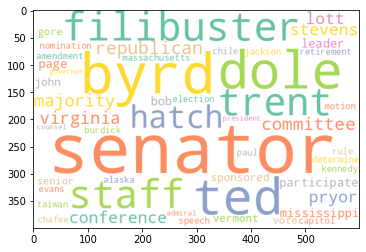

 190


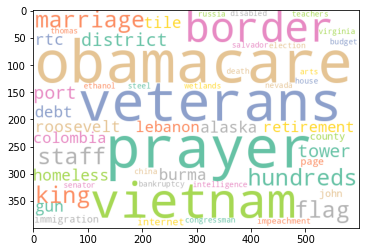

In [70]:
show_pic_list(df_base[df_base['sum'] > sum_max].sort_values(by="sum").index)

In [71]:
# small clusters to filter out
df_base[df_base['sum'] < sum_min]

81-82_D   81-82_R  83-84_D  83-84_R  85-86_D  85-86_R  87-88_D  87-88_R  \
62   0.000164  0.000357      0.0      0.0      0.0      0.0      0.0      0.0   
72   0.000123  0.000357      0.0      0.0      0.0      0.0      0.0      0.0   
158  0.000205  0.000134      0.0      0.0      0.0      0.0      0.0      0.0   
209  0.000328  0.000312      0.0      0.0      0.0      0.0      0.0      0.0   
224  0.000164  0.000178      0.0      0.0      0.0      0.0      0.0      0.0   
..        ...       ...      ...      ...      ...      ...      ...      ...   
820  0.000000  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
821  0.000000  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
824  0.000000  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
835  0.000000  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
839  0.000000  0.000000      0.0      0.0      0.0      0.0      0.0      0.0   

     89-90_D  89-90_R  ...  09-10_D  09-10_R  11-12_D  11-12_R  13-14_D  \
62       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
72       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
158      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
209      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
224      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
..       ...      ...  ...      ...      ...      ...      ...      ...   
820      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
821      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
824      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
835      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
839      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   

      13-14_R   15-16_D   15-16_R     sum   log_sum  
62   0.000000  0.000000  0.000000  0.0012 -6.725434  
72   0.000000  0.000000  0.000000  0.0011 -6.812445  
158  0.000000  0.000000  0.000000  0.0008 -7.130899  
209  0.000000  0.000000  0.000000  0.0015 -6.502290  
224  0.000000  0.000000  0.000000  0.0008 -7.130899  
..        ...       ...       ...     ...       ...  
820  0.001105  0.000000  0.000000  0.0015 -6.502290  
821  0.000000  0.000000  0.000860  0.0011 -6.812445  
824  0.000000  0.000313  0.000313  0.0008 -7.130899  
835  0.000000  0.000469  0.000391  0.0011 -6.812445  
839  0.000000  0.000469  0.000235  0.0009 -7.013116  

[65 rows x 38 columns]

In [72]:
# actual filtering
#df_base = df_base[(df_base['sum'] <= sum_max) & (df_base['sum'] >= sum_min)]
#df_base

In [73]:
# only keep same clusters in F/M df
df_cluster_F = df_cluster_F.filter(items=df_base.index, axis=0)
for idx in df_base.index:
    if idx not in df_cluster_F.index:
        df_cluster_F.loc[idx,:] = 0
df_cluster_F

year               81-82     83-84     85-86     87-88     89-90     91-92  \
global_cluster                                                               
0               0.028505  0.008916  0.023181  0.007303  0.018126  0.014017   
1               0.027735  0.008916  0.024259  0.009551  0.008842  0.013648   
2               0.000000  0.000000  0.000000  0.000000  0.000884  0.000738   
3               0.000770  0.000000  0.000000  0.000000  0.001768  0.001475   
5               0.003852  0.002743  0.000539  0.000562  0.001326  0.000000   
...                  ...       ...       ...       ...       ...       ...   
779             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
793             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
820             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
821             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
835             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

year               93-94     95-96     97-98     99-00     01-02     03-04  \
global_cluster                                                               
0               0.021869  0.043573  0.019405  0.007702  0.006664  0.010263   
1               0.018877  0.038780  0.030831  0.025402  0.021456  0.032668   
2               0.000000  0.000000  0.000000  0.000164  0.000000  0.000000   
3               0.000000  0.000000  0.006166  0.004916  0.002926  0.000000   
5               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
779             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
793             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
820             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
821             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
835             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

year               05-06     07-08     09-10     11-12     13-14     15-16  
global_cluster                                                              
0               0.011389  0.009959  0.005510  0.021931  0.031085  0.016225  
1               0.020582  0.012296  0.026606  0.039760  0.008833  0.006714  
2               0.000274  0.000000  0.000000  0.000000  0.000000  0.000000  
3               0.003019  0.001353  0.000000  0.000000  0.000000  0.000000  
5               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...                  ...       ...       ...       ...       ...       ...  
779             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
793             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
820             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
821             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
835             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[840 rows x 18 columns]

In [74]:
df_cluster_M = df_cluster_M.filter(items=df_base.index, axis=0)
for idx in df_base.index:
    if idx not in df_cluster_M.index:
        df_cluster_M.loc[idx,:] = 0
df_cluster_M

year               81-82     83-84     85-86     87-88     89-90     91-92  \
global_cluster                                                               
0               0.034037  0.011630  0.020464  0.012036  0.015277  0.020461   
1               0.035226  0.014485  0.025594  0.009388  0.013150  0.016825   
2               0.001849  0.000672  0.001415  0.000799  0.000614  0.001394   
3               0.000550  0.000000  0.000000  0.000000  0.001861  0.000909   
4               0.001431  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
835             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
836             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
837             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
838             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
839             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

year               93-94     95-96     97-98     99-00     01-02     03-04  \
global_cluster                                                               
0               0.018175  0.055369  0.026836  0.011393  0.012564  0.011605   
1               0.029320  0.043466  0.036612  0.036663  0.030049  0.034736   
2               0.000000  0.000000  0.000000  0.000143  0.000000  0.000000   
3               0.000000  0.000000  0.002783  0.001815  0.001464  0.000000   
4               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
835             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
836             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
837             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
838             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
839             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

year               05-06     07-08     09-10     11-12     13-14     15-16  
global_cluster                                                              
0               0.012873  0.008606  0.008993  0.028453  0.024286  0.013292  
1               0.025241  0.024371  0.040253  0.051474  0.012186  0.015971  
2               0.000224  0.000000  0.000000  0.000000  0.000000  0.000000  
3               0.002267  0.001266  0.000000  0.000000  0.000000  0.000000  
4               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...                  ...       ...       ...       ...       ...       ...  
835             0.000000  0.000000  0.000000  0.000000  0.000000  0.000546  
836             0.000000  0.000000  0.000000  0.000000  0.000000  0.001538  
837             0.000000  0.000000  0.000000  0.000000  0.000000  0.001934  
838             0.000000  0.000000  0.000000  0.000000  0.000000  0.000794  
839             0.000000  0.000000  0.000000  0.000000  0.000000  0.000248  

[840 rows x 18 columns]

In [75]:
df_summed_base = pd.DataFrame([
    df_base[yr + '_D'] + df_base[yr + '_R'] for yr in years
]).T

df_summed_base.columns = years
df_summed_base

81-82     83-84     85-86     87-88     89-90     91-92     93-94  \
0    0.067475  0.023107  0.041295  0.023936  0.030720  0.040763  0.036918   
1    0.070085  0.028757  0.051154  0.019056  0.026221  0.034822  0.058265   
2    0.003530  0.001301  0.002735  0.001512  0.001239  0.002780  0.000000   
3    0.001128  0.000000  0.000000  0.000000  0.003812  0.001934  0.000000   
4    0.002782  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
835  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
836  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
837  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
838  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
839  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        95-96     97-98     99-00     01-02     03-04     05-06     07-08  \
0    0.107989  0.051707  0.021848  0.023040  0.022994  0.025046  0.016344   
1    0.085809  0.071428  0.070573  0.057113  0.067889  0.048435  0.046867   
2    0.000000  0.000000  0.000293  0.000000  0.000000  0.000478  0.000000   
3    0.000000  0.006274  0.004423  0.003490  0.000000  0.005042  0.002617   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
835  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
836  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
837  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
838  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
839  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        09-10     11-12     13-14     15-16  
0    0.016592  0.055238  0.050513  0.027751  
1    0.079907  0.097377  0.023253  0.028068  
2    0.000000  0.000000  0.000000  0.000000  
3    0.000000  0.000000  0.000000  0.000000  
4    0.000000  0.000000  0.000000  0.000000  
..        ...       ...       ...       ...  
835  0.000000  0.000000  0.000000  0.000860  
836  0.000000  0.000000  0.000000  0.003205  
837  0.000000  0.000000  0.000000  0.003831  
838  0.000000  0.000000  0.000000  0.001564  
839  0.000000  0.000000  0.000000  0.000704  

[840 rows x 18 columns]

In [76]:
df_cluster_D = pd.DataFrame([
    df_base[yr + '_D'] for yr in years
]).T

df_cluster_D.columns = years

df_cluster_R = pd.DataFrame([
    df_base[yr + '_R'] for yr in years
]).T

df_cluster_R.columns = years

years_ts = pd.Series(range(1, len(years) + 1), index= years)

In [77]:
years_ts = pd.Series(range(1, len(years) + 1), index= years)
years_ts

81-82     1
83-84     2
85-86     3
87-88     4
89-90     5
91-92     6
93-94     7
95-96     8
97-98     9
99-00    10
01-02    11
03-04    12
05-06    13
07-08    14
09-10    15
11-12    16
13-14    17
15-16    18
dtype: int64

In [78]:
#df_base.drop(labels=["sum", 'log_sum'], axis=1, inplace=True)
df_base_stats = get_df_stats(df_base)
df_base_stats

mean       var  relative_var       std  relative_std  skewness  \
0    0.071455  0.068024      0.951971  0.068024      3.650011  5.565745   
1    0.101962  0.130406      1.278970  0.130406      3.541703  5.338288   
2   -0.087013  0.296523     -3.407795  0.296523     -6.258125 -6.163365   
3   -0.069207  0.195771     -2.828779  0.195771     -6.393299 -6.158764   
4   -0.132281  0.667458     -5.045764  0.667458     -6.176110 -6.164397   
..        ...       ...           ...       ...           ...       ...   
835 -0.179223  1.221319     -6.814512  1.221319     -6.166236 -6.164414   
836 -0.144460  0.795175     -5.504482  0.795175     -6.172841 -6.164407   
837 -0.139731  0.744453     -5.327744  0.744453     -6.174828 -6.164403   
838 -0.163449  1.016383     -6.218367  1.016383     -6.168047 -6.164413   
839 -0.184513  1.294326     -7.014807  1.294326     -6.165862 -6.164414   

     zeros       sum   log_sum   kurtosis  
0        0  2.715309  0.998906  32.160302  
1        0  3.874537  1.354426  29.726393  
2       20 -3.306501       NaN  37.991212  
3       20 -2.629860       NaN  37.953112  
4       34 -5.026671       NaN  37.999854  
..     ...       ...       ...        ...  
835     34 -6.810485       NaN  37.999997  
836     34 -5.489463       NaN  37.999942  
837     34 -5.309789       NaN  37.999911  
838     34 -6.211044       NaN  37.999989  
839     34 -7.011512       NaN  37.999998  

[840 rows x 10 columns]

In [79]:
df_summed_stats = get_df_stats(df_summed_base, years_ts)
df_summed_stats

mean           var  relative_var           std  relative_std  \
0    0.037960  5.183018e-04      0.013654  5.183018e-04      0.599747   
1    0.053615  5.485440e-04      0.010231  5.485440e-04      0.436833   
2    0.000770  1.342163e-06      0.001742  1.342163e-06      1.503723   
3    0.001596  4.535091e-06      0.002842  4.535091e-06      1.334723   
4    0.000155  4.300770e-07      0.002782  4.300770e-07      4.242641   
..        ...           ...           ...           ...           ...   
835  0.000048  4.108346e-08      0.000860  4.108346e-08      4.242641   
836  0.000178  5.707118e-07      0.003205  5.707118e-07      4.242641   
837  0.000213  8.154906e-07      0.003831  8.154906e-07      4.242641   
838  0.000087  1.358502e-07      0.001564  1.358502e-07      4.242641   
839  0.000039  2.749590e-08      0.000704  2.749590e-08      4.242641   

     skewness  zeros       sum   log_sum   kurtosis  kendall_tau   p_value  \
0    1.898919      0  0.683275 -0.380858   4.401014    -0.163399  0.368581   
1    0.125851      0  0.965078 -0.035546  -1.023625     0.084967  0.654029   
2    1.390744     10  0.013868 -4.278187   0.726734    -0.606788  0.001109   
3    0.986917     10  0.028719 -3.550185  -0.404324    -0.062235  0.738005   
4    4.242641     17  0.002782 -5.884465  18.000000    -0.333333  0.101347   
..        ...    ...       ...       ...        ...          ...       ...   
835  4.242641     17  0.000860 -7.058644  18.000000     0.333333  0.101347   
836  4.242641     17  0.003205 -5.743005  18.000000     0.333333  0.101347   
837  4.242641     17  0.003831 -5.564552  18.000000     0.333333  0.101347   
838  4.242641     17  0.001564 -6.460671  18.000000     0.333333  0.101347   
839  4.242641     17  0.000704 -7.259429  18.000000     0.333333  0.101347   

    is_monotonic_increasing is_monotonic_decreasing  
0                     False                   False  
1                     False                   False  
2                     False                   False  
3                     False                   False  
4                     False                    True  
..                      ...                     ...  
835                    True                   False  
836                    True                   False  
837                    True                   False  
838                    True                   False  
839                    True                   False  

[840 rows x 14 columns]

In [80]:
df_cluster_D_stats = get_df_stats(df_cluster_D, years_ts)
df_cluster_D_stats

mean           var  relative_var           std  relative_std  \
0    0.019102  1.156630e-04      0.006055  1.156630e-04      0.563005   
1    0.023812  1.736161e-04      0.007291  1.736161e-04      0.553358   
2    0.000413  4.602276e-07      0.001113  4.602276e-07      1.640900   
3    0.000555  5.269443e-07      0.000949  5.269443e-07      1.307904   
4    0.000075  1.019783e-07      0.001355  1.019783e-07      4.242641   
..        ...           ...           ...           ...           ...   
835  0.000026  1.221276e-08      0.000469  1.221276e-08      4.242641   
836  0.000104  1.954041e-07      0.001875  1.954041e-07      4.242641   
837  0.000078  1.099148e-07      0.001407  1.099148e-07      4.242641   
838  0.000035  2.171156e-08      0.000625  2.171156e-08      4.242641   
839  0.000026  1.221276e-08      0.000469  1.221276e-08      4.242641   

     skewness  zeros       sum   log_sum   kurtosis  kendall_tau   p_value  \
0    1.823379      0  0.343841 -1.067577   3.574349    -0.019608  0.940516   
1    0.738709      0  0.428609 -0.847210  -0.200170     0.071895  0.708881   
2    2.012821     10  0.007442 -4.900645   4.389078    -0.622347  0.000823   
3    0.871535     10  0.009990 -4.606140  -0.773732    -0.093352  0.615847   
4    4.242641     17  0.001355 -6.604067  18.000000    -0.333333  0.101347   
..        ...    ...       ...       ...        ...          ...       ...   
835  4.242641     17  0.000469 -7.665207  18.000000     0.333333  0.101347   
836  4.242641     17  0.001875 -6.278912  18.000000     0.333333  0.101347   
837  4.242641     17  0.001407 -6.566594  18.000000     0.333333  0.101347   
838  4.242641     17  0.000625 -7.377525  18.000000     0.333333  0.101347   
839  4.242641     17  0.000469 -7.665207  18.000000     0.333333  0.101347   

    is_monotonic_increasing is_monotonic_decreasing  
0                     False                   False  
1                     False                   False  
2                     False                   False  
3                     False                   False  
4                     False                    True  
..                      ...                     ...  
835                    True                   False  
836                    True                   False  
837                    True                   False  
838                    True                   False  
839                    True                   False  

[840 rows x 14 columns]

In [81]:
df_cluster_R_stats = get_df_stats(df_cluster_R, years_ts)
df_cluster_R_stats

mean           var  relative_var           std  relative_std  \
0    0.018857  1.558430e-04      0.008264  1.558430e-04      0.662004   
1    0.029804  1.771014e-04      0.005942  1.771014e-04      0.446518   
2    0.000357  2.877296e-07      0.000806  2.877296e-07      1.502531   
3    0.001041  2.102793e-06      0.002021  2.102793e-06      1.393655   
4    0.000079  1.132068e-07      0.001427  1.132068e-07      4.242641   
..        ...           ...           ...           ...           ...   
835  0.000022  8.497008e-09      0.000391  8.497008e-09      4.242641   
836  0.000074  9.822542e-08      0.001330  9.822542e-08      4.242641   
837  0.000135  3.266250e-07      0.002425  3.266250e-07      4.242641   
838  0.000052  4.894277e-08      0.000939  4.894277e-08      4.242641   
839  0.000013  3.058923e-09      0.000235  3.058923e-09      4.242641   

     skewness  zeros       sum   log_sum   kurtosis  kendall_tau   p_value  \
0    1.817485      0  0.339434 -1.080475   4.325920    -0.254902  0.151923   
1    0.413295      0  0.536469 -0.622746  -0.472578     0.084967  0.654029   
2    1.501276     10  0.006426 -5.047402   1.258663    -0.575671  0.001974   
3    1.255587     10  0.018729 -3.977680   0.585713    -0.062235  0.738005   
4    4.242641     17  0.001427 -6.551839  18.000000    -0.333333  0.101347   
..        ...    ...       ...       ...        ...          ...       ...   
835  4.242641     17  0.000391 -7.846590  18.000000     0.333333  0.101347   
836  4.242641     17  0.001330 -6.622815  18.000000     0.333333  0.101347   
837  4.242641     17  0.002425 -6.022041  18.000000     0.333333  0.101347   
838  4.242641     17  0.000939 -6.971121  18.000000     0.333333  0.101347   
839  4.242641     17  0.000235 -8.357416  18.000000     0.333333  0.101347   

    is_monotonic_increasing is_monotonic_decreasing  
0                     False                   False  
1                     False                   False  
2                     False                   False  
3                     False                   False  
4                     False                    True  
..                      ...                     ...  
835                    True                   False  
836                    True                   False  
837                    True                   False  
838                    True                   False  
839                    True                   False  

[840 rows x 14 columns]

In [82]:
df_cluster_F_stats = get_df_stats(df_cluster_F, years_ts)
df_cluster_F_stats

mean           var  relative_var           std  \
global_cluster                                                       
0               0.016979  1.029863e-04      0.006065  1.029863e-04   
1               0.020875  1.128898e-04      0.005408  1.128898e-04   
2               0.000114  7.013980e-08      0.000613  7.013980e-08   
3               0.001244  3.513649e-06      0.002824  3.513649e-06   
5               0.000501  1.188687e-06      0.002371  1.188687e-06   
...                  ...           ...           ...           ...   
779             0.000000  0.000000e+00           NaN  0.000000e+00   
793             0.000000  0.000000e+00           NaN  0.000000e+00   
820             0.000000  0.000000e+00           NaN  0.000000e+00   
821             0.000000  0.000000e+00           NaN  0.000000e+00   
835             0.000000  0.000000e+00           NaN  0.000000e+00   

                relative_std  skewness  zeros       sum   log_sum  kurtosis  \
global_cluster                                                                
0                   0.597685  1.136851      0  0.305626 -1.185395  1.245206   
1                   0.508974  0.288884      0  0.375754 -0.978820 -1.045643   
2                   2.313890  2.427433     14  0.002060 -6.184946  4.991907   
3                   1.506688  1.606697     10  0.022394 -3.798970  1.892469   
5                   2.175052  2.441825     13  0.009023 -4.708011  5.442011   
...                      ...       ...    ...       ...       ...       ...   
779                      NaN  0.000000     18  0.000000      -inf  0.000000   
793                      NaN  0.000000     18  0.000000      -inf  0.000000   
820                      NaN  0.000000     18  0.000000      -inf  0.000000   
821                      NaN  0.000000     18  0.000000      -inf  0.000000   
835                      NaN  0.000000     18  0.000000      -inf  0.000000   

                kendall_tau   p_value is_monotonic_increasing  \
global_cluster                                                  
0                 -0.084967  0.654029                   False   
1                  0.006536  1.000000                   False   
2                 -0.123208  0.528991                   False   
3                 -0.077793  0.675859                   False   
5                 -0.644129  0.000856                   False   
...                     ...       ...                     ...   
779                     NaN       NaN                    True   
793                     NaN       NaN                    True   
820                     NaN       NaN                    True   
821                     NaN       NaN                    True   
835                     NaN       NaN                    True   

               is_monotonic_decreasing  
global_cluster                          
0                                False  
1                                False  
2                                False  
3                                False  
5                                False  
...                                ...  
779                               True  
793                               True  
820                               True  
821                               True  
835                               True  

[840 rows x 14 columns]

In [83]:
df_cluster_M_stats = get_df_stats(df_cluster_M, years_ts)
df_cluster_M_stats

mean           var  relative_var           std  \
global_cluster                                                       
0               0.019242  1.341416e-04      0.006971  1.341416e-04   
1               0.027501  1.461446e-04      0.005314  1.461446e-04   
2               0.000395  3.584517e-07      0.000908  3.584517e-07   
3               0.000718  8.970499e-07      0.001250  8.970499e-07   
4               0.000080  1.137734e-07      0.001431  1.137734e-07   
...                  ...           ...           ...           ...   
835             0.000030  1.653658e-08      0.000546  1.653658e-08   
836             0.000085  1.313360e-07      0.001538  1.313360e-07   
837             0.000107  2.078689e-07      0.001934  2.078689e-07   
838             0.000044  3.498648e-08      0.000794  3.498648e-08   
839             0.000014  3.416648e-09      0.000248  3.416648e-09   

                relative_std  skewness  zeros       sum   log_sum   kurtosis  \
global_cluster                                                                 
0                   0.601921  1.997322      0  0.346350 -1.060306   4.795432   
1                   0.439593  0.180423      0  0.495009 -0.703179  -0.839394   
2                   1.515850  1.416983     10  0.007109 -4.946341   0.847290   
3                   1.319957  0.952927     10  0.012916 -4.349304  -0.469886   
4                   4.242641  4.242641     17  0.001431 -6.549343  18.000000   
...                      ...       ...    ...       ...       ...        ...   
835                 4.242641  4.242641     17  0.000546 -7.513660  18.000000   
836                 4.242641  4.242641     17  0.001538 -6.477568  18.000000   
837                 4.242641  4.242641     17  0.001934 -6.247993  18.000000   
838                 4.242641  4.242641     17  0.000794 -7.138966  18.000000   
839                 4.242641  4.242641     17  0.000248 -8.302117  18.000000   

                kendall_tau   p_value is_monotonic_increasing  \
global_cluster                                                  
0                 -0.137255  0.454263                   False   
1                  0.124183  0.500867                   False   
2                 -0.622347  0.000823                   False   
3                 -0.077793  0.675859                   False   
4                 -0.333333  0.101347                   False   
...                     ...       ...                     ...   
835                0.333333  0.101347                    True   
836                0.333333  0.101347                    True   
837                0.333333  0.101347                    True   
838                0.333333  0.101347                    True   
839                0.333333  0.101347                    True   

               is_monotonic_decreasing  
global_cluster                          
0                                False  
1                                False  
2                                False  
3                                False  
4                                 True  
...                                ...  
835                              False  
836                              False  
837                              False  
838                              False  
839                              False  

[840 rows x 14 columns]

In [84]:
df_cluster_D.to_pickle(data_path[data_set] + "df_cluster_D.pkl")
df_cluster_R.to_pickle(data_path[data_set] + "df_cluster_R.pkl")
df_cluster_F.to_pickle(data_path[data_set] + "df_cluster_F.pkl")
df_cluster_M.to_pickle(data_path[data_set] + "df_cluster_M.pkl")
df_cluster_D_stats.to_pickle(data_path[data_set] + "df_cluster_D_stats.pkl")
df_cluster_R_stats.to_pickle(data_path[data_set] + "df_cluster_R_stats.pkl")
df_cluster_F_stats.to_pickle(data_path[data_set] + "df_cluster_F_stats.pkl")
df_cluster_M_stats.to_pickle(data_path[data_set] + "df_cluster_M_stats.pkl")

In [85]:
df_speech.to_pickle("./HD_Analysis/df_speech.pkl")
df_speaker_map.to_pickle("./HD_Analysis/df_speaker_map.pkl")
df_descr.to_pickle("./HD_Analysis/df_descr.pkl")

Below we retrieved two clusters with high kendall_tau value (-0.76 & -0.75) as well as very high p_value (0.000011 0.000066	)
This indicates both clluster is negatively correlated to the timeseries we created, meaning these clusters represent declining topic.

In [140]:
kt_th = 0.6
p_val_th =  0.1
n = 5
# apply basic time series operation
df_cluster_D_stats_sort_by_kt_head = get_kt_head(df_cluster_D_stats, kt_th, p_val_th, n)
df_cluster_R_stats_sort_by_kt_head = get_kt_head(df_cluster_R_stats, kt_th, p_val_th, n)

kt_cmp_DR_head = df_cluster_D_stats_sort_by_kt_head  + [
    x for x in df_cluster_R_stats_sort_by_kt_head if x not in df_cluster_D_stats_sort_by_kt_head ]

df_cluster_D_stats_sort_by_kt_tail = get_kt_tail(df_cluster_D_stats, kt_th, p_val_th, n)
df_cluster_R_stats_sort_by_kt_tail = get_kt_tail(df_cluster_R_stats, kt_th, p_val_th, n)
kt_cmp_DR_tail = df_cluster_D_stats_sort_by_kt_tail  + [
    x for x in df_cluster_R_stats_sort_by_kt_tail if x not in df_cluster_D_stats_sort_by_kt_tail ]

idx: 68


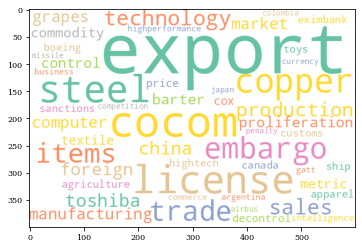

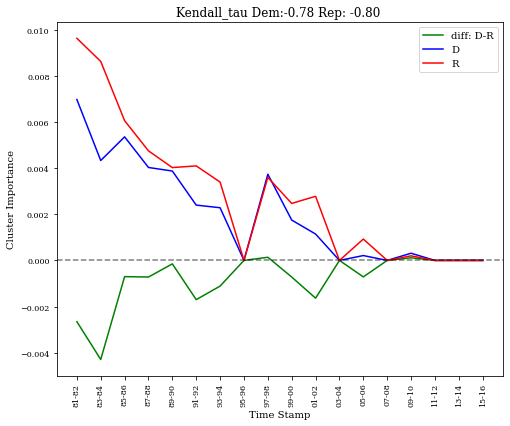

------------------------------------------------------------------------------------------------------------------------------
idx: 177


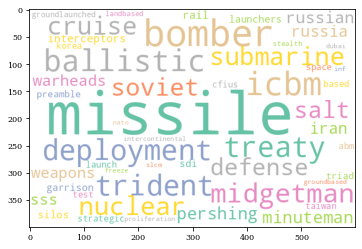

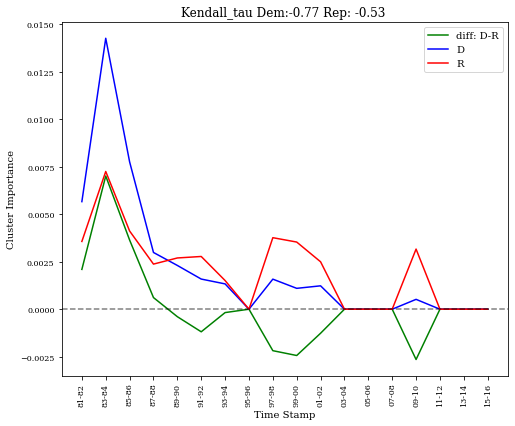

------------------------------------------------------------------------------------------------------------------------------
idx: 97


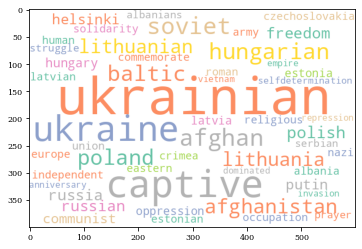

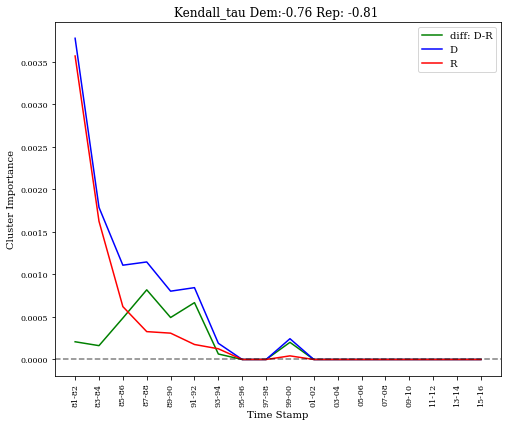

------------------------------------------------------------------------------------------------------------------------------
idx: 143


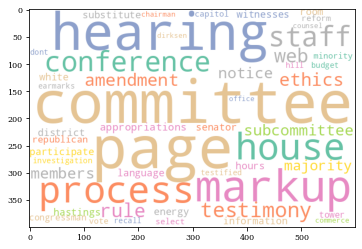

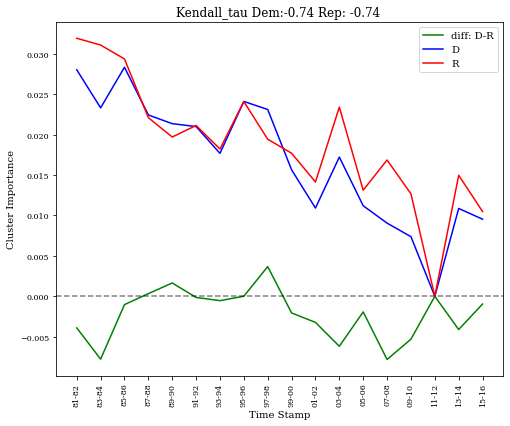

------------------------------------------------------------------------------------------------------------------------------
idx: 22


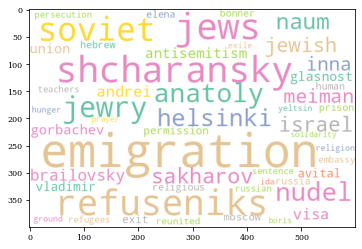

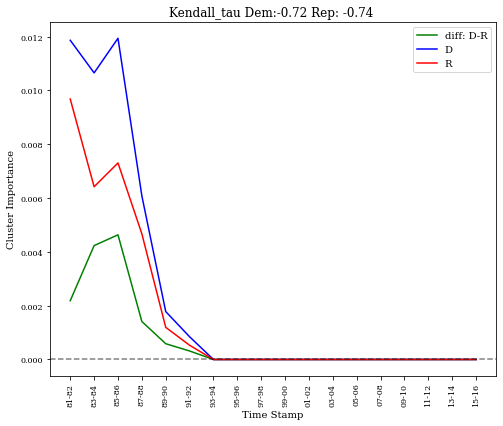

------------------------------------------------------------------------------------------------------------------------------
idx: 159


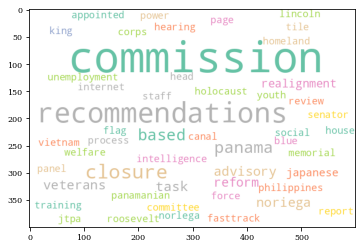

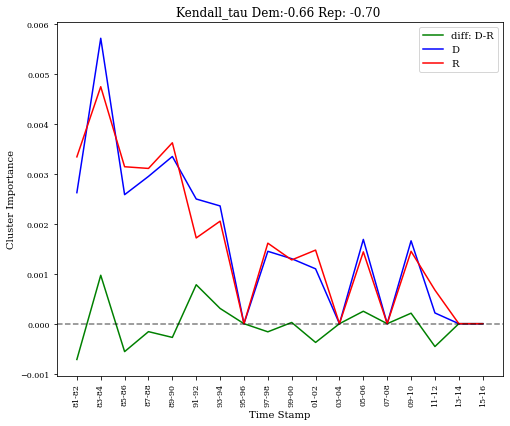

------------------------------------------------------------------------------------------------------------------------------


In [141]:
show_by_metric('kendall_tau', kt_cmp_DR_head, cat="DR")

idx: 704


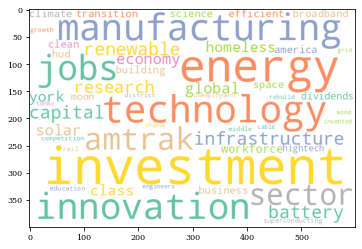

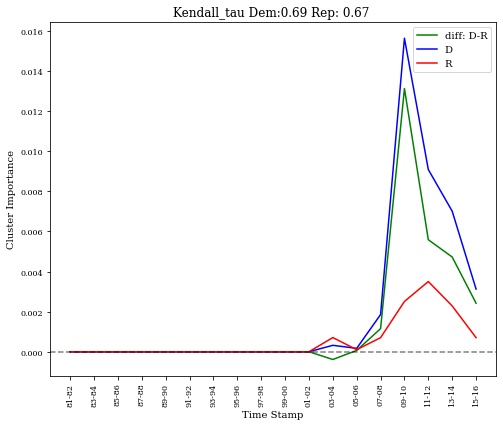

------------------------------------------------------------------------------------------------------------------------------
idx: 573


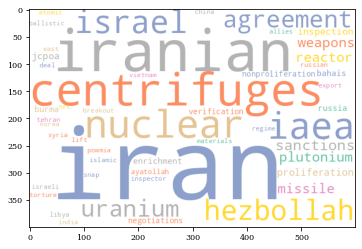

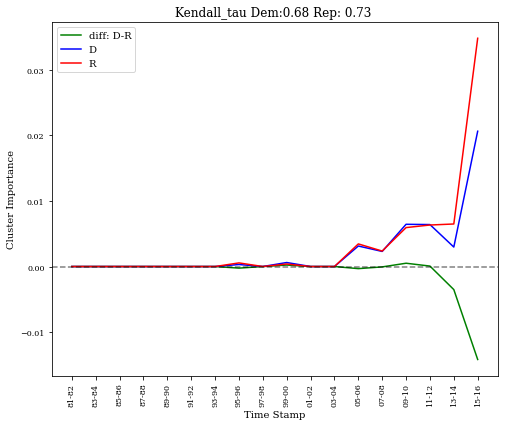

------------------------------------------------------------------------------------------------------------------------------
idx: 737


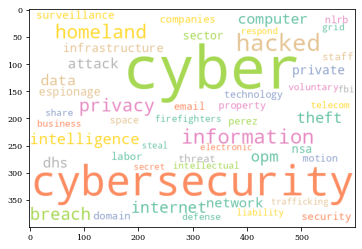

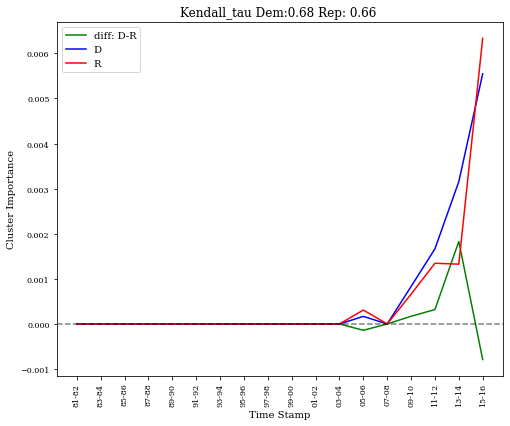

------------------------------------------------------------------------------------------------------------------------------
idx: 632


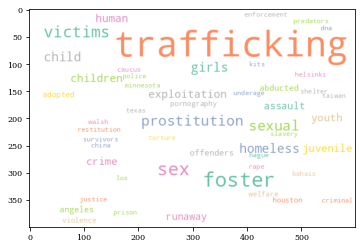

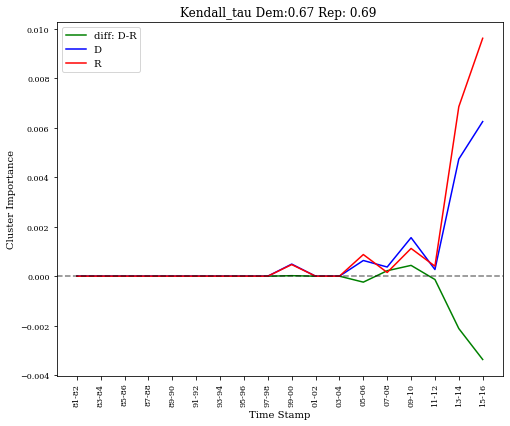

------------------------------------------------------------------------------------------------------------------------------
idx: 560


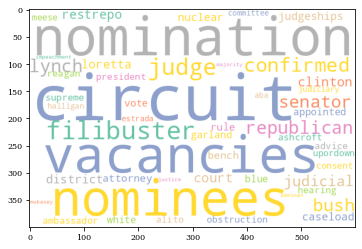

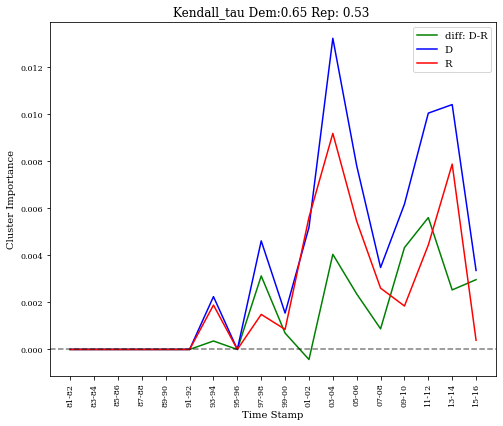

------------------------------------------------------------------------------------------------------------------------------
idx: 402


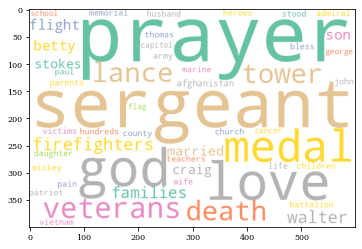

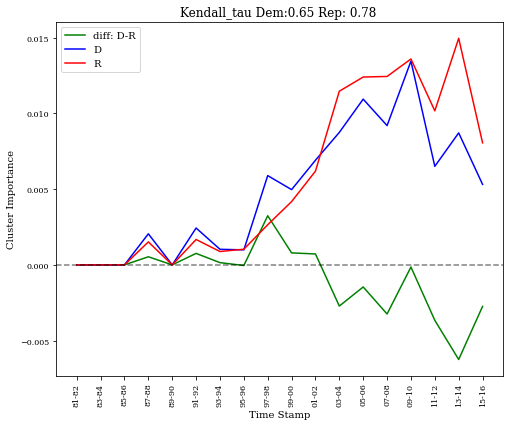

------------------------------------------------------------------------------------------------------------------------------
idx: 616


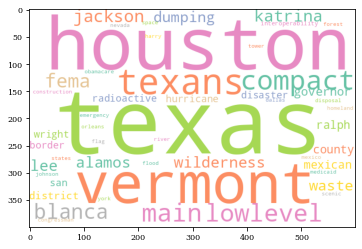

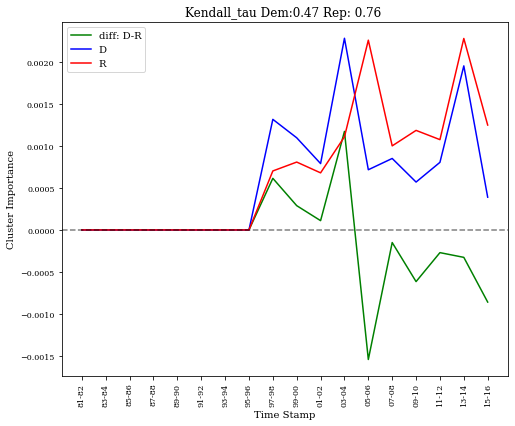

------------------------------------------------------------------------------------------------------------------------------
idx: 445


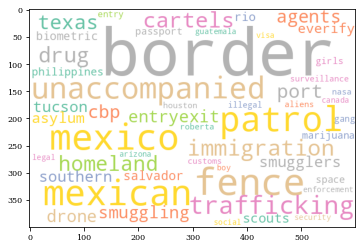

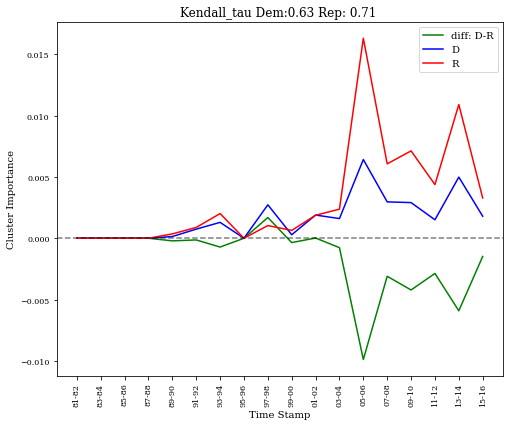

------------------------------------------------------------------------------------------------------------------------------


In [142]:
show_by_metric('kendall_tau', kt_cmp_DR_tail, cat="DR")

idx: 137


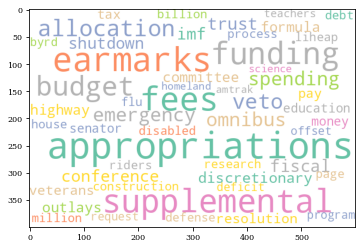

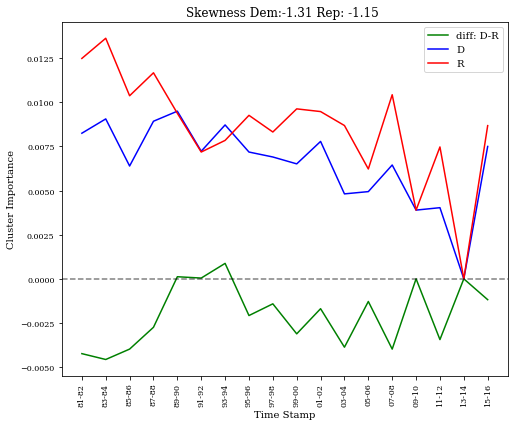

------------------------------------------------------------------------------------------------------------------------------
idx: 18


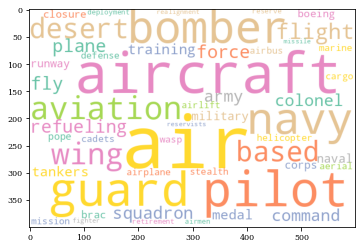

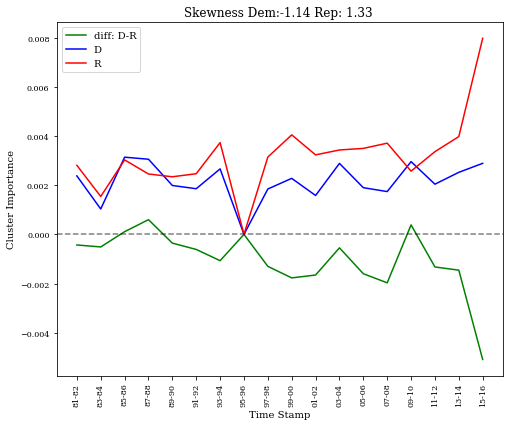

------------------------------------------------------------------------------------------------------------------------------
idx: 58


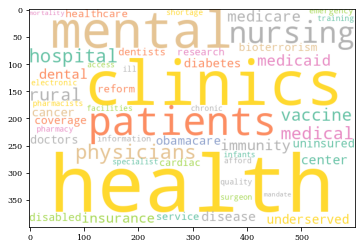

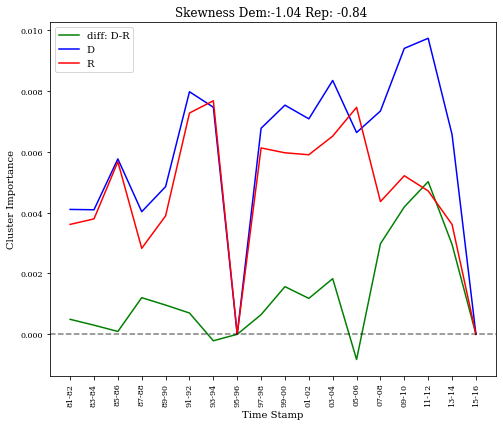

------------------------------------------------------------------------------------------------------------------------------
idx: 130


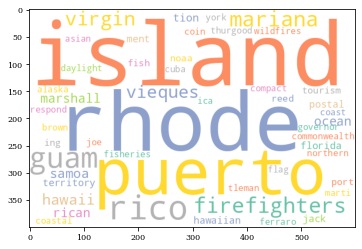

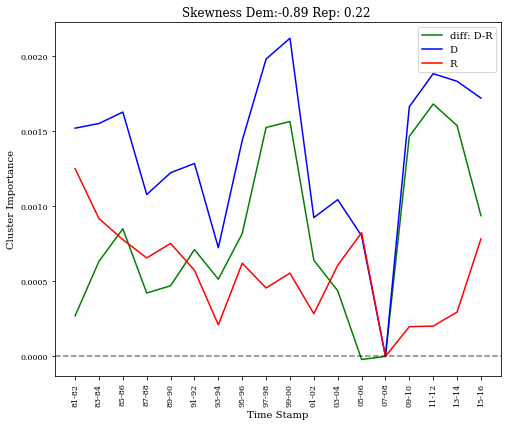

------------------------------------------------------------------------------------------------------------------------------
idx: 11


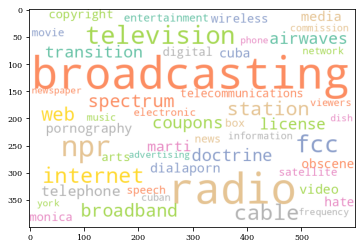

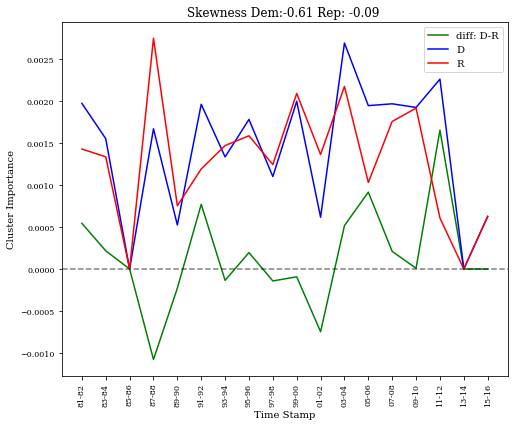

------------------------------------------------------------------------------------------------------------------------------
idx: 99


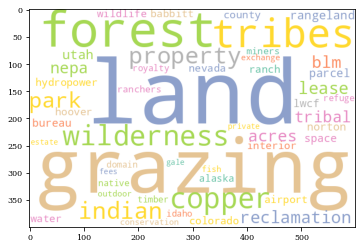

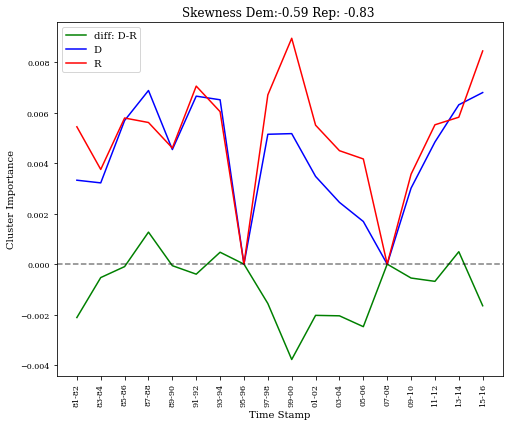

------------------------------------------------------------------------------------------------------------------------------
idx: 211


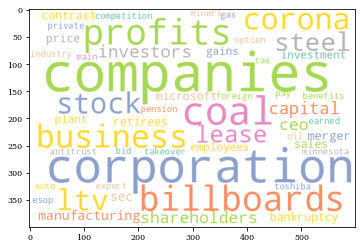

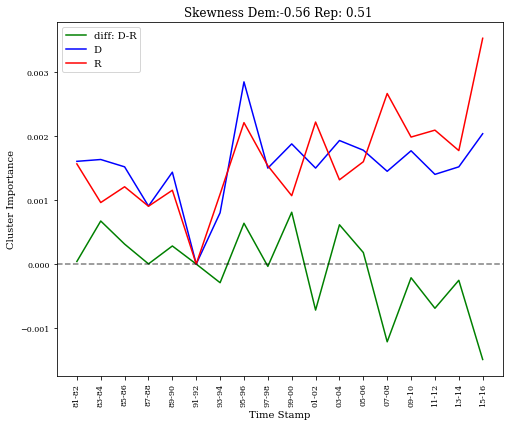

------------------------------------------------------------------------------------------------------------------------------
idx: 148


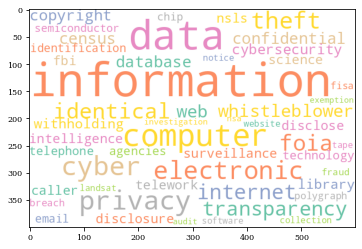

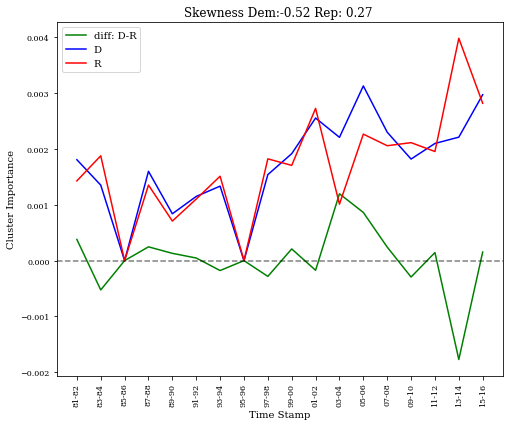

------------------------------------------------------------------------------------------------------------------------------
idx: 206


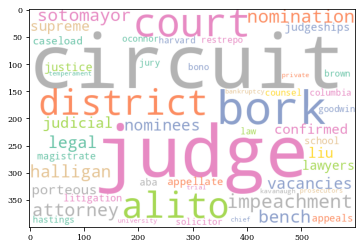

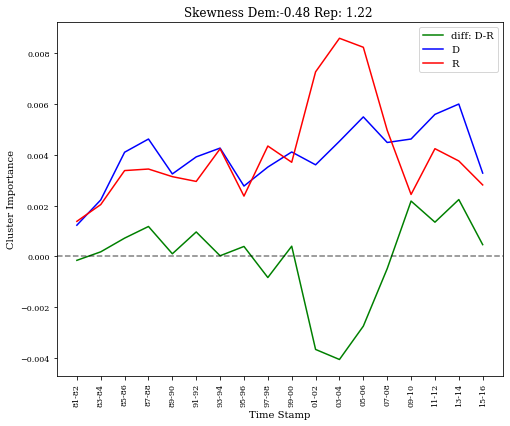

------------------------------------------------------------------------------------------------------------------------------
idx: 191


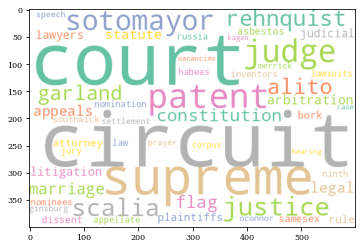

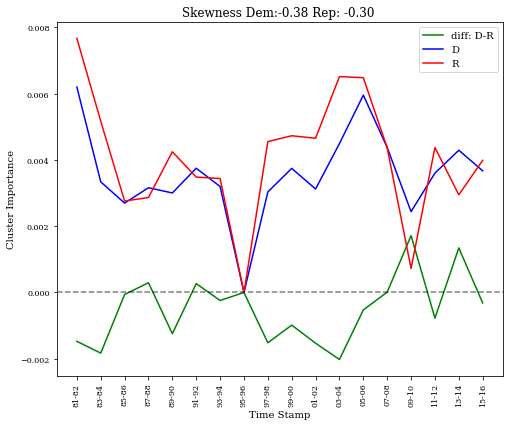

------------------------------------------------------------------------------------------------------------------------------
idx: 216


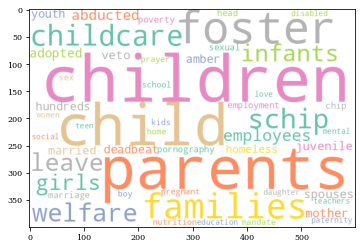

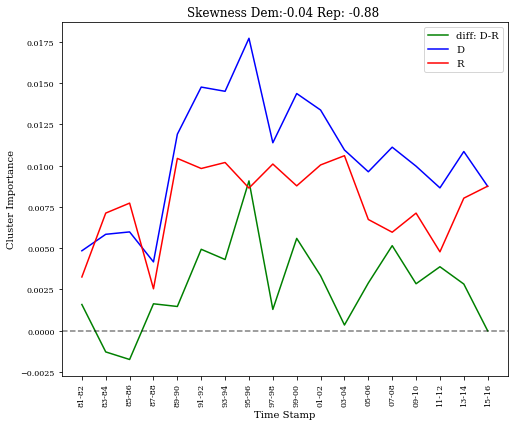

------------------------------------------------------------------------------------------------------------------------------
idx: 70


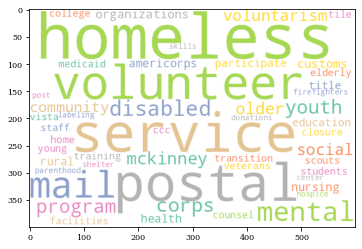

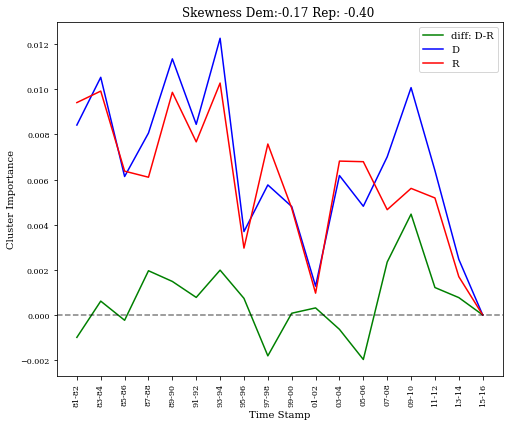

------------------------------------------------------------------------------------------------------------------------------
idx: 213


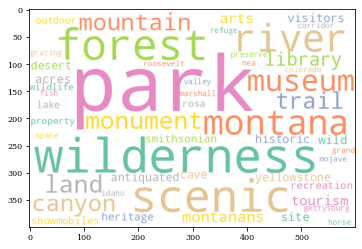

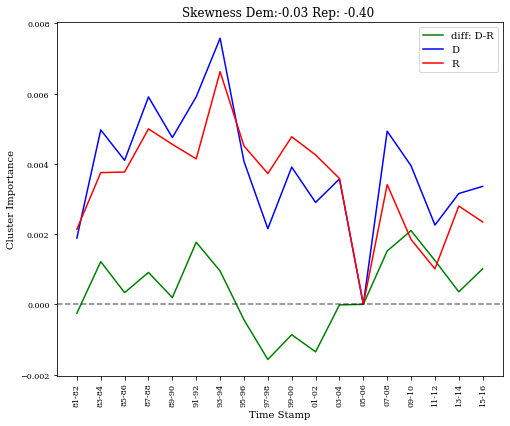

------------------------------------------------------------------------------------------------------------------------------
idx: 143


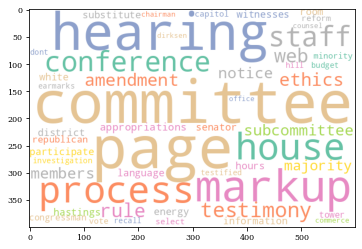

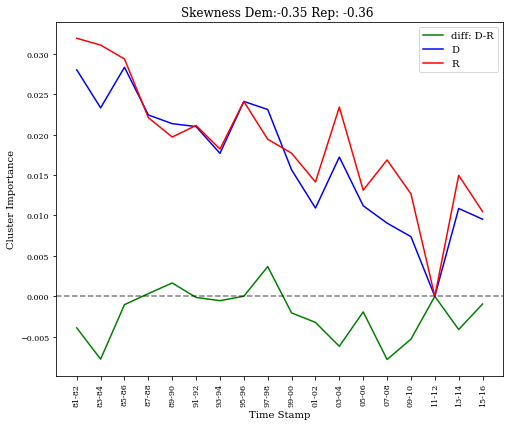

------------------------------------------------------------------------------------------------------------------------------
idx: 210


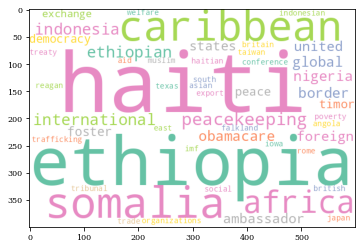

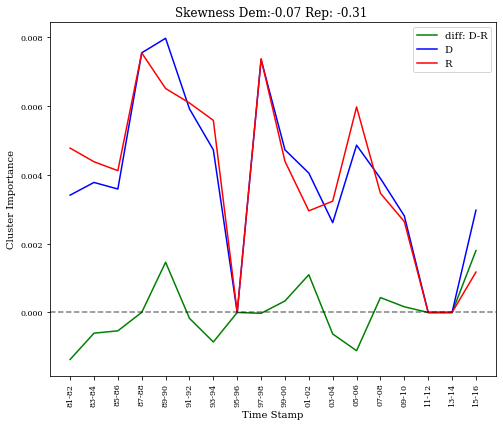

------------------------------------------------------------------------------------------------------------------------------
idx: 129


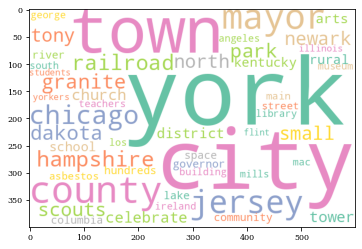

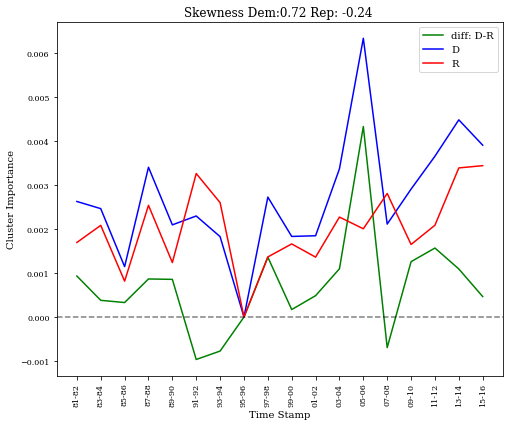

------------------------------------------------------------------------------------------------------------------------------


In [143]:
df_cluster_D_stats_sort_by_skew_head = get_sorted_idx_by_moment_head(df_cluster_D_stats, "skewness", 10)
df_cluster_R_stats_sort_by_skew_head = get_sorted_idx_by_moment_head(df_cluster_R_stats, "skewness", 10)
skew_cmp_DR_head = df_cluster_D_stats_sort_by_skew_head + [
    x for x in df_cluster_R_stats_sort_by_skew_head if x not in df_cluster_D_stats_sort_by_skew_head
]

show_by_metric('skewness', skew_cmp_DR_head, cat="DR")

idx: 751


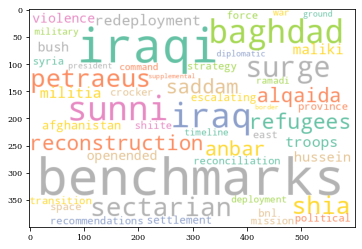

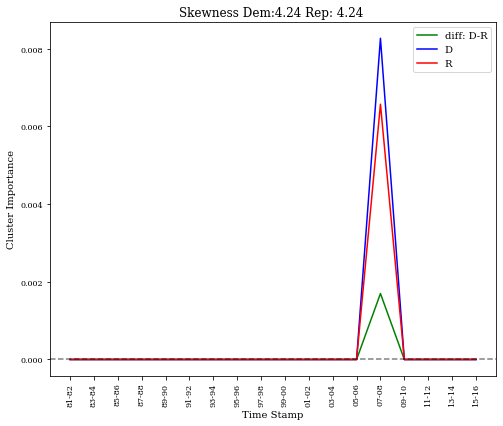

------------------------------------------------------------------------------------------------------------------------------
idx: 465


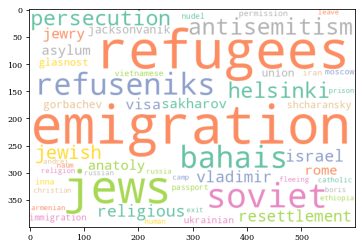

D max value lower than threshold: 0.0007334707135622228
R max value lower than threshold: 0.0007522123893805309


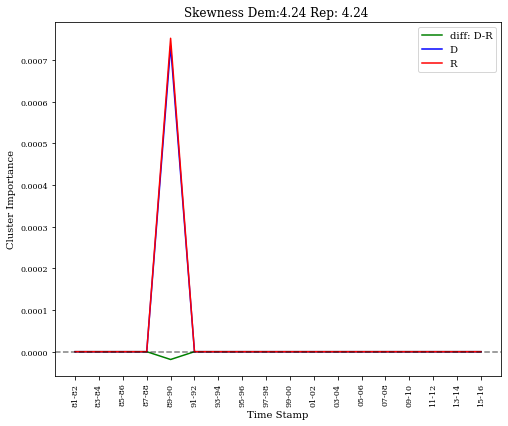

------------------------------------------------------------------------------------------------------------------------------
idx: 610


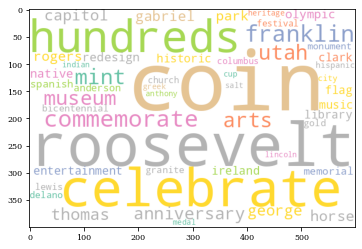

D max value lower than threshold: 0.0006157635467980296
R max value lower than threshold: 0.0004967709885742673


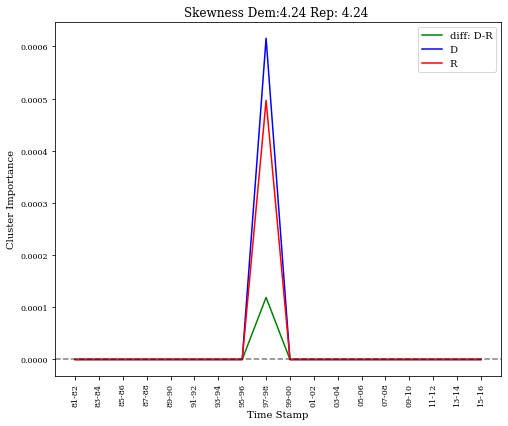

------------------------------------------------------------------------------------------------------------------------------
idx: 769


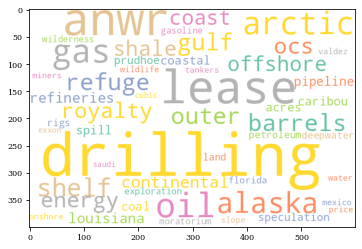

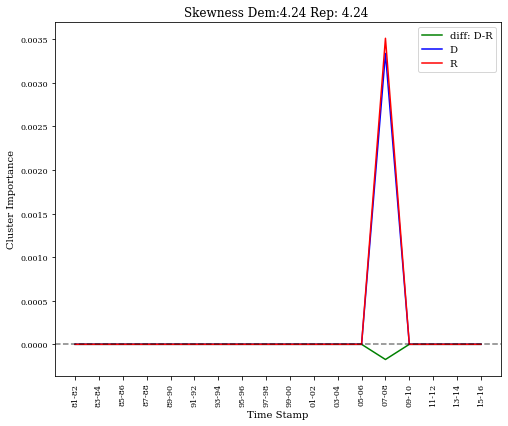

------------------------------------------------------------------------------------------------------------------------------
idx: 782


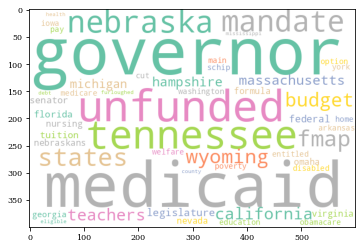

D max value lower than threshold: 0.0005713098576919082


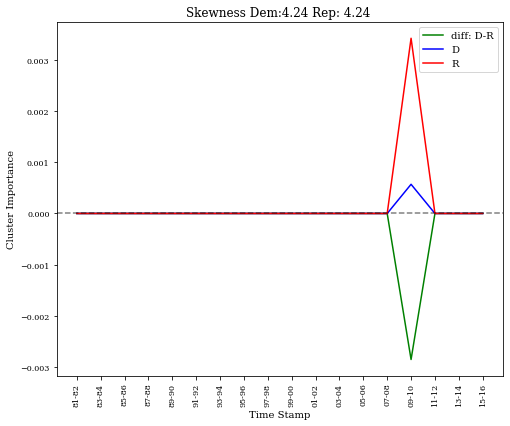

------------------------------------------------------------------------------------------------------------------------------
idx: 289


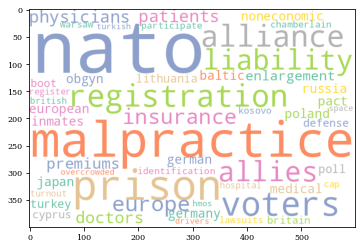

D max value lower than threshold: 0.00011924636298592892
R max value lower than threshold: 0.00016675699337140952


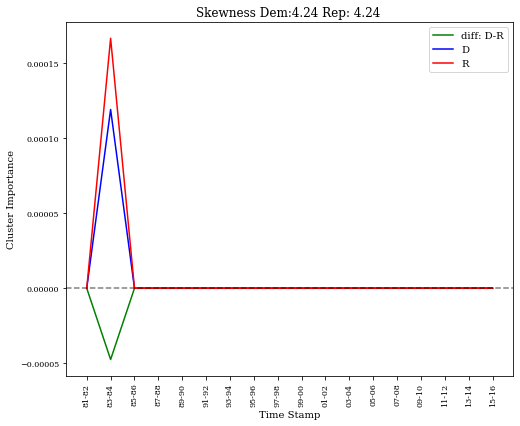

------------------------------------------------------------------------------------------------------------------------------
idx: 582


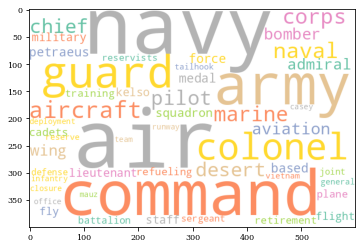

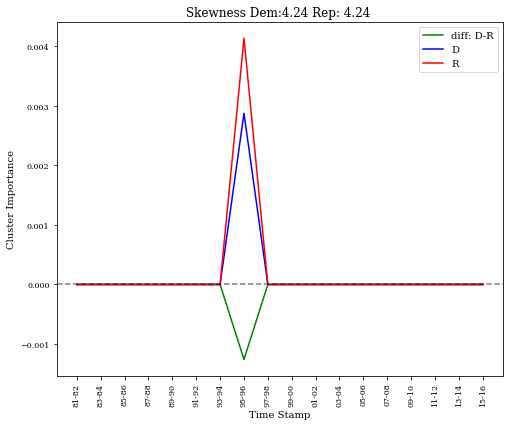

------------------------------------------------------------------------------------------------------------------------------
idx: 757


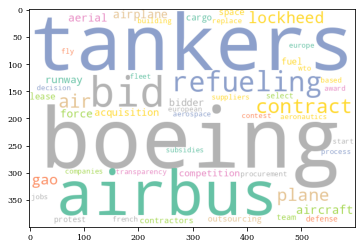

D max value lower than threshold: 0.000852767787623744
R max value lower than threshold: 0.0004012639815418568


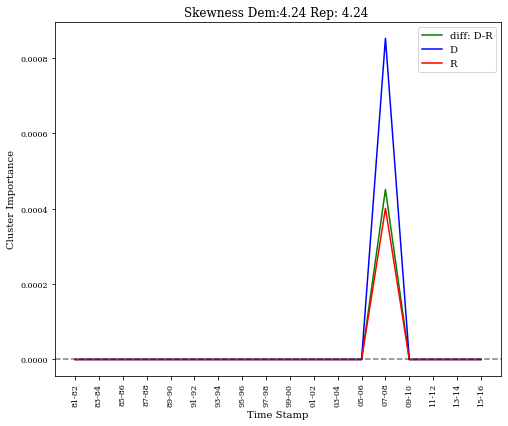

------------------------------------------------------------------------------------------------------------------------------
idx: 119


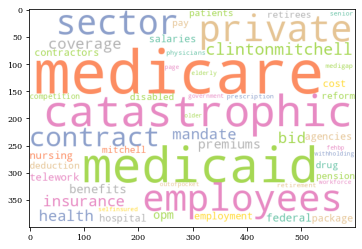

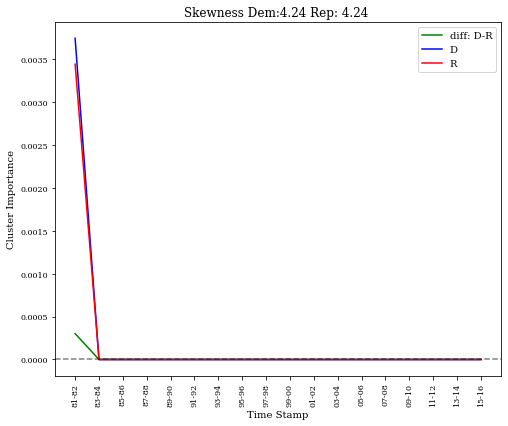

------------------------------------------------------------------------------------------------------------------------------
idx: 764


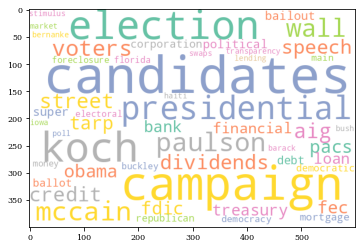

D max value lower than threshold: 0.0002224611619888028
R max value lower than threshold: 5.01579976927321e-05


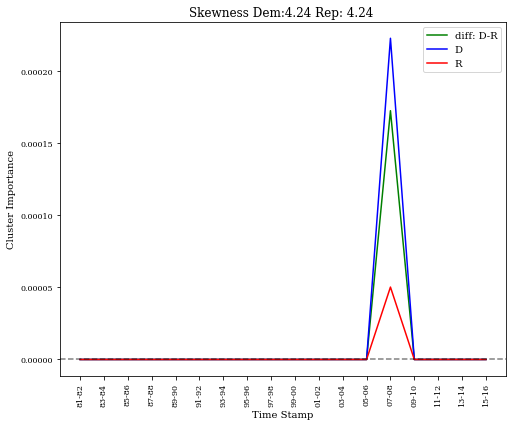

------------------------------------------------------------------------------------------------------------------------------


In [145]:
df_cluster_D_stats_sort_by_skew_tail = get_sorted_idx_by_moment_tail(df_cluster_D_stats, "skewness", 5)
df_cluster_R_stats_sort_by_skew_tail = get_sorted_idx_by_moment_tail(df_cluster_R_stats, "skewness", 5)

skew_cmp_DR_tail = df_cluster_D_stats_sort_by_skew_tail + [
    x for x in df_cluster_R_stats_sort_by_skew_tail if x not in df_cluster_D_stats_sort_by_skew_tail
]

show_by_metric('skewness', skew_cmp_DR_tail, cat="DR")

idx: 297


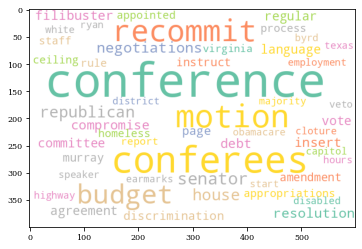

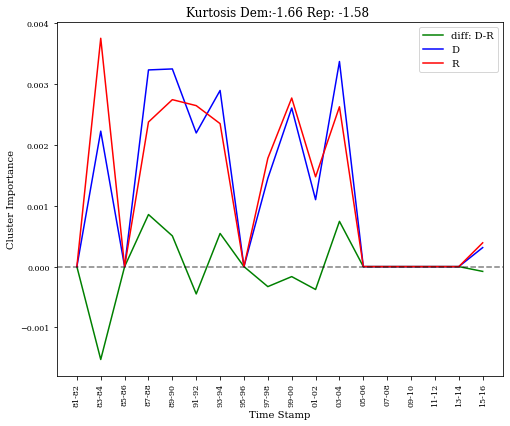

------------------------------------------------------------------------------------------------------------------------------
idx: 271


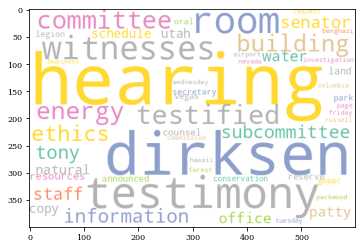

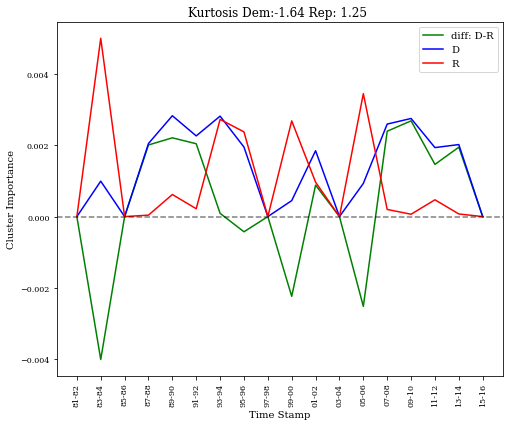

------------------------------------------------------------------------------------------------------------------------------
idx: 449


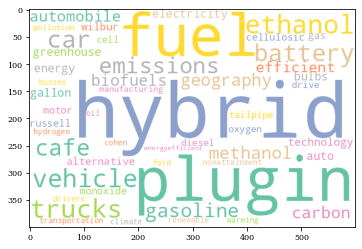

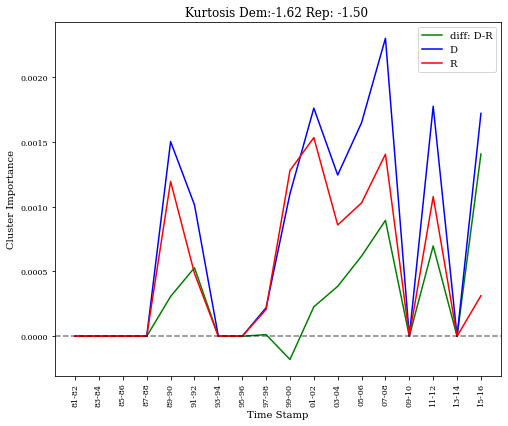

------------------------------------------------------------------------------------------------------------------------------
idx: 120


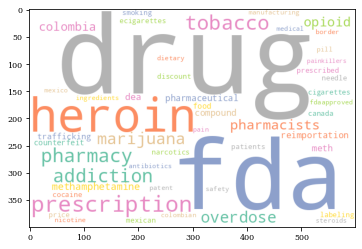

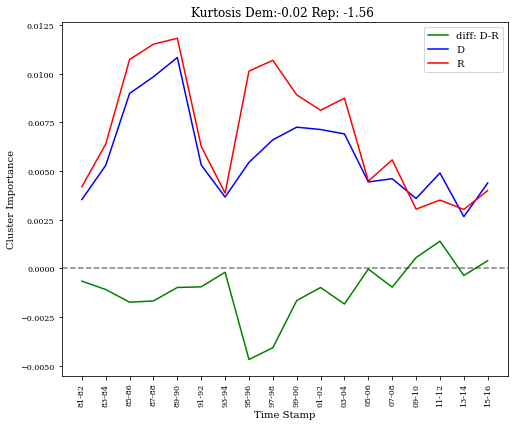

------------------------------------------------------------------------------------------------------------------------------
idx: 366


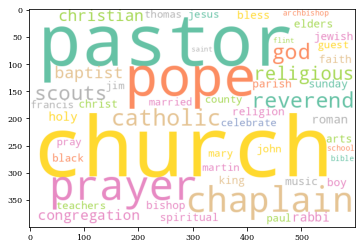

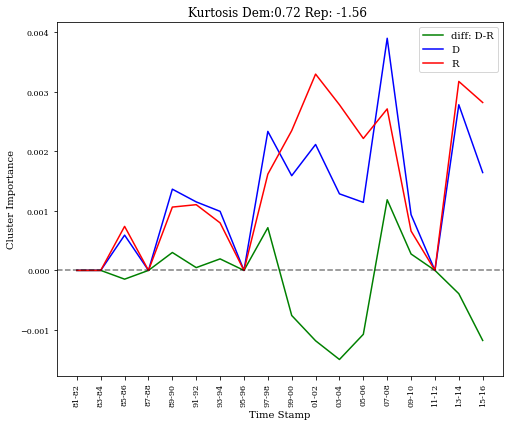

------------------------------------------------------------------------------------------------------------------------------


In [148]:
df_cluster_D_stats_sort_by_kurt_head = get_sorted_idx_by_moment_head(df_cluster_D_stats, "kurtosis", 3)
df_cluster_R_stats_sort_by_kurt_head = get_sorted_idx_by_moment_head(df_cluster_R_stats, "kurtosis", 3)
kurt_cmp_DR_head = df_cluster_D_stats_sort_by_kurt_head + [
    x for x in df_cluster_R_stats_sort_by_kurt_head if x not in df_cluster_D_stats_sort_by_kurt_head
]

show_by_metric('kurtosis', kurt_cmp_DR_head, cat="DR")

idx: 228


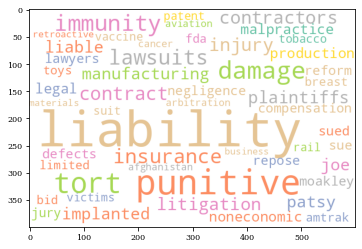

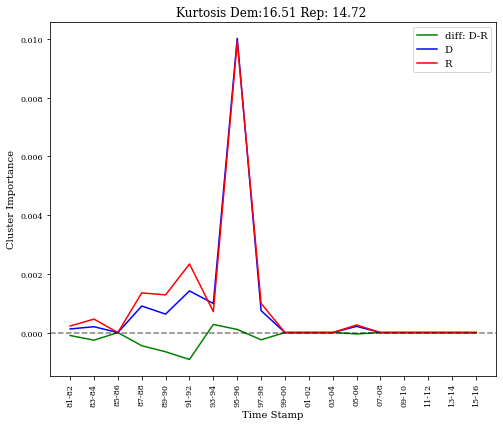

------------------------------------------------------------------------------------------------------------------------------
idx: 232


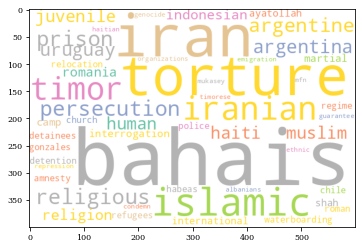

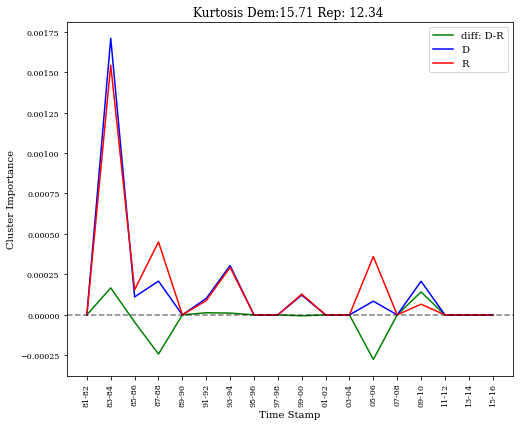

------------------------------------------------------------------------------------------------------------------------------
idx: 71


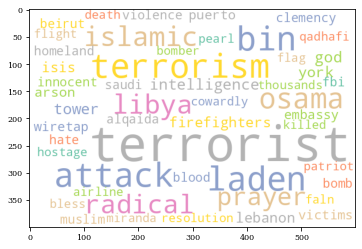

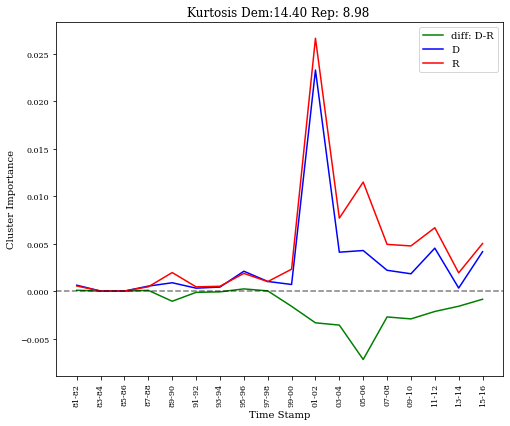

------------------------------------------------------------------------------------------------------------------------------
idx: 141


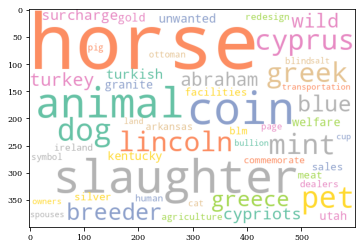

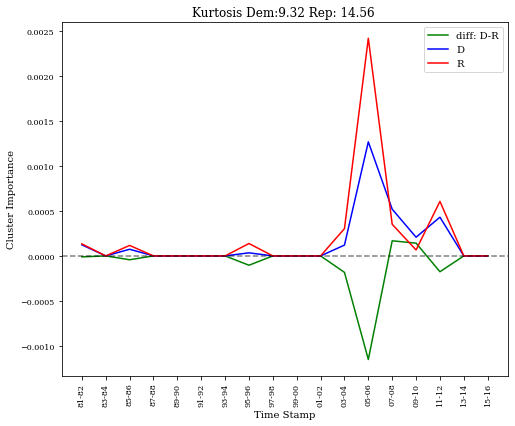

------------------------------------------------------------------------------------------------------------------------------
idx: 573


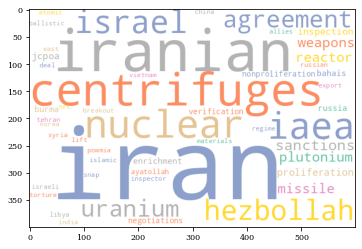

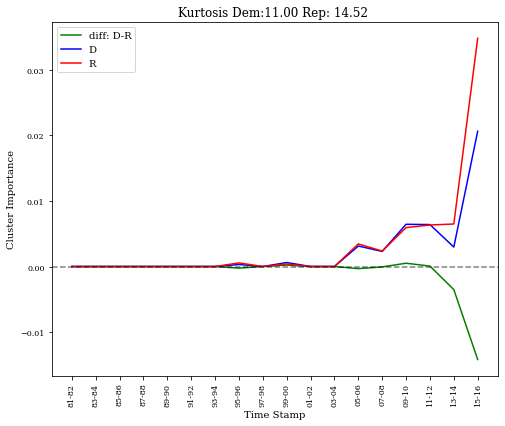

------------------------------------------------------------------------------------------------------------------------------


In [149]:


df_cluster_D_stats_sort_by_kurt_tail = get_sorted_idx_by_moment_tail(
    df_cluster_D_stats[df_cluster_D_stats["zeros"]<=10], "kurtosis", 3)
df_cluster_R_stats_sort_by_kurt_tail = get_sorted_idx_by_moment_tail(
    df_cluster_R_stats[df_cluster_R_stats["zeros"]<=10], "kurtosis", 3)
kurt_cmp_DR_tail = df_cluster_D_stats_sort_by_kurt_tail + [
    x for x in df_cluster_R_stats_sort_by_kurt_tail if x not in df_cluster_D_stats_sort_by_kurt_tail
]

show_by_metric('kurtosis', kurt_cmp_DR_tail, cat="DR")

The negative skew are too small for any meaningful investigation
For clusters with postitive skew, most value are lower than mean, with few high values
They represent something rarely talked about but occassionlly become talk of the time

In [96]:
df_speech

year party  local_cluster   speech_id  global_cluster  neuron  \
0       81-82     D            376   970000037             111    5262   
1       81-82     D            461   970000183             145    7010   
2       81-82     D            389   970000185             115    5818   
3       81-82     D            676   970000192             213    9469   
4       81-82     D            404   970000194             120    5429   
...       ...   ...            ...         ...             ...     ...   
808194  15-16     R            114  1140112237             190     899   
808195  15-16     R            234  1140112239             203     898   
808196  15-16     R            114  1140112241             190    6060   
808197  15-16     R             39  1140112243             222    5519   
808198  15-16     R            214  1140112245             364    9512   

        local_p0  local_p1 chamber      date         state gender  char_count  \
0           62.0      52.0       S  19810105       Unknown      M        2264   
1           10.0      70.0       S  19810105       Unknown      M        5347   
2           18.0      58.0       S  19810105       Unknown      M        3119   
3           69.0      94.0       S  19810105       Unknown      M        4040   
4           29.0      54.0       S  19810105       Unknown      M        3050   
...          ...       ...     ...       ...           ...    ...         ...   
808194      99.0       8.0       H  20160909          Iowa      M        1482   
808195      98.0       8.0       H  20160909       Unknown      M        1026   
808196      60.0      60.0       H  20160909  Pennsylvania      M        1153   
808197      18.5      55.0       H  20160909       Unknown      M        1744   
808198      11.5      95.0       H  20160909       Unknown      M        1041   

        word_count  speakerid  district  nonvoting  
0              415   97114621         0      False  
1              824   97109651         0      False  
2              508   97108781         0      False  
3              649   97107681         0      False  
4              517   97108511         0      False  
...            ...        ...       ...        ...  
808194         271  114123000         3      False  
808195         166  114123320         4      False  
808196         181  114121520         5      False  
808197         295  114121990         1      False  
808198         179  114122790        10      False  

[806594 rows x 17 columns]

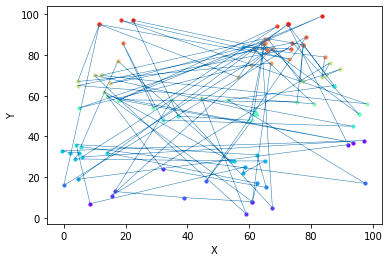

In [97]:
data = df_speech[df_speech['gender'] == 'M'][['local_p0','local_p1']].head(100)
label = df_speech[df_speech['gender'] == 'M']['global_cluster'].head(100)
plot_trajectory_2d(data.to_numpy(), label.to_numpy())

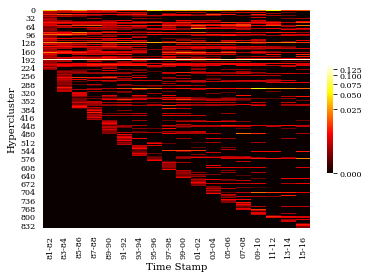

In [116]:
tex_fonts = {
	# Use LaTeX to write all text
	"font.family": "serif",
	# Use 10pt font in plots, to match 10pt font in document
	"axes.labelsize": 10,
	"font.size": 10,
	# Make the legend/label fonts a little smaller
	#"legend.fontsize": 8,
	"xtick.labelsize": 8,
	"ytick.labelsize": 8
}
ylabels = {"topic":"Global Topic", "cluster": "Hypercluster"}

def gen_heat_map(df, filename="example.pdf", norm=None,kind="topic",figsize=None,name=None):
	plt.rcParams.update(tex_fonts)
	plt.tick_params(
		axis='both', # changes apply to the x-axis
		which='both', # both major and minor ticks are affected
		bottom=False, # ticks along the bottom edge are off
		top=False, # ticks along the top edge are off
		left=False,
		right=False,
		#labelbottom=False,
		#labelleft=False 
        )
	cmap = 'hot'
	if figsize is None:
		figsize=myfigsize
        
	if norm is None:
		norm = PowerNorm(gamma=0.3)
	sns.heatmap(df,cmap=cmap, norm=norm,cbar_kws={"shrink": 0.5})
	plt.xlabel("Time Stamp")
	plt.ylabel(ylabels[kind])
	#plt.yticks([], [])
	if name is not None and len(name) == 2:
		plt.title(name[0] + "_" + name[1])
		plt.savefig(name[0] + "_" + name[1] + "_heatmap.pdf", bbox_inches='tight')
	else:
		plt.savefig(filename, bbox_inches='tight')  
	return

gen_heat_map(df_cluster_D, "Cluster_D_Heatmap.pdf",kind="cluster")

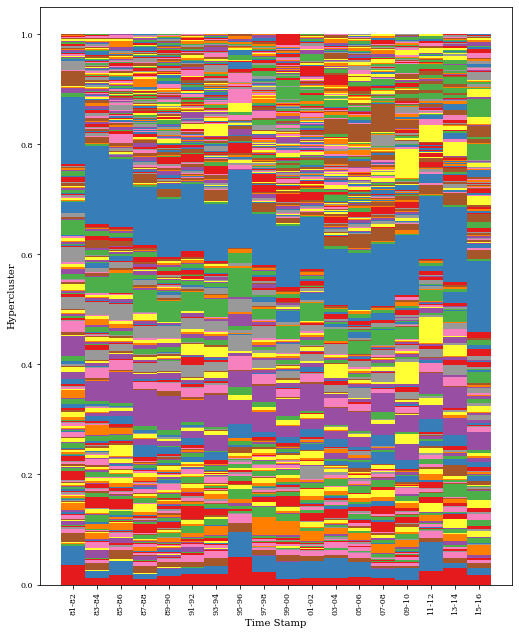

In [139]:
def gen_stack_plot(df, filename="example.pdf",kind="topic",name=None):	

	
	plt.rcParams.update(tex_fonts)
    
	plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)	
	ax = df.T.plot(kind='bar', stacked=True, width=1.0, legend=False, figsize=myfigsize)
	ax.autoscale()
	plt.xlabel("Time Stamp")
	plt.ylabel(ylabels[kind])
	#plt.yticks([], [])
	if name is not None and len(name) == 2:
		plt.title(name[0] + "_" + name[1])
		plt.savefig(name[0] + "_" + name[1] + "_stack_plot.pdf", bbox_inches='tight')
	else:
		plt.savefig(filename, bbox_inches='tight')
	plt.show()
	return
gen_stack_plot(df_cluster_D, 'Cluster_D_Stacked.pdf',kind="cluster")